# Bayesian Analysis of Falcon 9 Landing Success and Reuse Economics

# 1. Executive Summary

This project estimates Falcon 9 booster landing reliability using a hierarchical Bayesian model and evaluates the financial value of reuse under asymmetric payoffs. The model separates hardware capability from mission difficulty, which helps explain why landing outcomes vary across flights.

Block 5 shows the highest intrinsic reliability, with an underlying landing probability of about 83%. But realised landing performance depends strongly on orbit class. High‑energy missions impose greater re‑entry loads and tighter propellant margins, which reduce operational landing probabilities even for Block 5. Low‑energy LEO missions are less demanding and therefore achieve higher realised reliability.

The economic analysis uses these posterior landing probabilities to assess whether reuse creates value. Under the assumed payoff structure—a `$`10 M gain for a successful landing and a `$`50 M loss for booster replacement—the breakeven landing probability is about 54%. Block 5 exceeds this threshold in roughly 79% of posterior draws, giving an expected reuse value of about $8 M. Catastrophic‑loss probability is low (about 2%), and the 5th‑percentile economic outcome (VaR₅) is approximately –`$`32 M.

Overall, the modelling framework provides a clear and statistically grounded view of Falcon 9 reuse. The results reflect the limits of public data and simplified cost assumptions, but the approach is transparent, robust, and suitable for extension with richer engineering or financial information.

**Key Insight:**

Block 5 is the most reliable Falcon 9 booster, but reuse economics depend more on orbit class than on Block number. High‑energy missions depress realised landing probabilities because they are inherently harder, while LEO‑class missions often approach breakeven or positive expected value. Distinguishing hardware capability from mission profile is essential for understanding the financial viability of booster recovery.

# 2. Introduction and Business Problem

This notebook examines Falcon 9 booster landing reliability using a hierarchical Bayesian model. The goal is to understand how design changes, mission profiles, and operational factors influence landing outcomes, and to estimate the economic value of reuse under uncertainty.

The analysis uses publicly available mission data and a small set of engineered features that capture the main sources of variation. The hierarchical structure allows the model to handle uneven sample sizes across Blocks, Orbits, and Launch Sites, and to express appropriate uncertainty for groups with limited data.

The results provide mission‑specific landing probabilities, Block‑level reliability trends, and an expected‑value assessment of reuse economics. The focus is clarity and interpretability rather than exhaustive modelling. The framework is transparent, statistically principled, and designed to extend naturally to richer engineering or financial datasets.

## The Core Question

Falcon 9 boosters can be reused, but only if the landing succeeds. A failed landing destroys the booster, the payload, and often the mission. Because the upside and downside are asymmetric, the central question is:

**At what landing reliability does booster reuse become economically worthwhile?**

## Report Organization

This report is organised into three macro‑blocks:

- Problem & Data: Sections 1–2

- Modelling & Reliability: Sections 3–6

- Economics & Conclusions: Sections 7–9

## Analytical Approach

This project combines:

### A hierarchical Bayesian reliability model
- Estimates landing probability using the full flight record  
- Captures differences between hardware Blocks  
- Stabilises estimates for Blocks with limited data  
- Produces mission‑specific predictions with uncertainty  

### A probabilistic economic model
- Converts reliability into expected value  
- Uses the corrected asymmetric‑risk breakeven formula  
- Computes expected value, probability of profit, and Value‑at‑Risk  
- Includes catastrophic‑loss sensitivity analysis  

## Why Bayesian Methods?

Falcon 9 landing data are small, imbalanced, and structured by hardware generation; 90 missions, unevenly distributed across Blocks. A hierarchical Bayesian model:

- pools information across Blocks  
- avoids overconfidence  
- handles partial pooling naturally  
- provides full posterior distributions  

This makes it well suited for aerospace reliability analysis.

## Key Findings

- Block 5 landing reliability: ~83%
(posterior mean 0.826, median ≈0.83, 95% CI [0.497, 0.976])

- Breakeven reliability: ~54%

- Expected value of reuse: ~$8M

- Probability of profit: ~79%
(posterior mass above 0.54 = 0.7935)

- Catastrophic‑loss probability: ~2%
(posterior mass below 0.20 = 0.0205)

- VaR₅: –$32M  
(5th percentile of economic outcome distribution)

## Scope and Limitations

This analysis uses public data and simplified cost assumptions. It is intended to provide strategic insight, not operational reliability guarantees.

The dataset covers a limited number of Falcon 9 missions and lacks detailed engineering telemetry, payload characteristics, and mission‑specific risk factors. The model does not include:

- landing type (RTLS vs ASDS)

- booster age or reuse count

- weather

- thrust‑to‑weight

- trajectory profile

Several Blocks, especially Block 2 and Block 3, have very small sample sizes. The hierarchical structure shrinks these estimates toward the group mean, which increases uncertainty and limits the model’s ability to distinguish fine‑grained differences between similar missions.

Economic results rely on stylised cost assumptions and a simplified treatment of catastrophic loss. These values are useful for comparing scenarios but should not be read as precise financial forecasts. The analysis assumes independence between missions and does not model correlated failures or systemic risk.

The economic model excludes payload loss, which is treated as insured or outside the operator’s balance sheet. Payload values vary widely and are not available in the dataset, so the downside risk reflects booster replacement only rather than full mission‑level exposure.

Overall, the findings highlight strategic trends in reuse economics and reliability, but they should be interpreted with appropriate caution given the data and modelling constraints.


# 3. Data Preparation

This section loads and prepares the Falcon 9 launch dataset for modelling. The goal is to structure the data so the hierarchical Bayesian model can separately estimate:

- Intrinsic Block‑level reliability (hardware capability)

- Orbit‑specific difficulty (mission profile)

- Launch‑site effects (environmental and operational factors)

These distinctions become important later when interpreting operational vs intrinsic reliability.

### 3.1 Import and Load data

We begin by loading the mission‑level dataset, which includes:

- booster Block number

- orbit class

- launch site

- landing outcome (success/failure)

- mission metadata

The raw data contains categorical variables that must be encoded for the model.

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid", context="talk")
np.random.seed(42)

# Load data
data = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
)
X_raw = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"
)

/home/ndrew/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
import os
os.makedirs("figures", exist_ok=True)

### 3.2 Encoding Block, Orbit, and Site

To support hierarchical modelling, we convert the categorical variables into integer indices:

- Block → 0, 1, 2, 3, 4 (corresponding to Blocks 1–5)

- Orbit class → LEO‑class, High‑Energy, Other

- Launch site → encoded by site identifier

These encodings allow the model to estimate:

- a Block effect (intrinsic reliability)

- an Orbit effect (mission difficulty)

- a Site effect (environmental/operational variation)

This is the foundation for the intrinsic vs operational reliability distinction used later in the analysis. 


### 3.3 Creating the Modelling Variables

We construct the following arrays for the Bayesian model:

- y — binary landing outcome (1 = success, 0 = failure)

- block_idx — integer Block index

- orbit_idx — integer orbit class index

- site_idx — integer launch site index

These variables feed directly into the logistic regression model in Section 4.

In [3]:
# --- 1. Clean and collapse raw categories ---

# Orbit: collapse into LEO-class, High-Energy, Other
def simplify_orbit(o):
    if o in ["LEO", "ISS", "VLEO"]:
        return "LEO-class"
    elif o in ["GTO", "GEO", "Mars", "Moon"]:
        return "High-Energy"
    else:
        return "Other"

data["Orbit_cat"] = data["Orbit"].apply(simplify_orbit)

# Launch site: collapse into 3 categories
def simplify_site(s):
    if "CCAFS" in s:
        return "CCAFS"
    elif "KSC" in s:
        return "KSC"
    elif "VAFB" in s:
        return "VAFB"
    else:
        return "Other"

data["Site_cat"] = data["LaunchSite"].apply(simplify_site)

# Block: ensure categorical
data["Block_cat"] = data["Block"].astype("category")

# --- 2. Convert to categorical dtype ---
data["Orbit_cat"] = data["Orbit_cat"].astype("category")
data["Site_cat"] = data["Site_cat"].astype("category")
data["Block_cat"] = data["Block_cat"].astype("category")

# --- 3. Create integer index columns for PyMC ---
data["Orbit_idx"] = data["Orbit_cat"].cat.codes
data["Site_idx"] = data["Site_cat"].cat.codes
data["Block_idx"] = data["Block_cat"].cat.codes

# --- 4. Extract model inputs ---
orbit_idx = data["Orbit_idx"].values
site_idx = data["Site_idx"].values
block_idx = data["Block_idx"].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mass_scaled = scaler.fit_transform(data[["PayloadMass"]]).flatten()

Y = data["Class"].values

n_orbits = data["Orbit_cat"].nunique()
n_sites = data["Site_cat"].nunique()
n_blocks = data["Block_cat"].nunique()

print("Preprocessing complete.")
print("n_orbits:", n_orbits, "n_sites:", n_sites, "n_blocks:", n_blocks)


Preprocessing complete.
n_orbits: 3 n_sites: 3 n_blocks: 5


These variables form the design matrix for the Bayesian model in Section 5.

### 3.4 Why This Preparation Matters

This structure allows the model to:

- estimate Block‑level reliability independent of mission difficulty

- estimate orbit‑specific penalties for high‑energy trajectories

- correctly shrink sparse categories toward the global mean

- produce operational reliability by combining Block + Orbit + Site effects

This is the key to understanding why Block 5’s intrinsic reliability (~88%) differs from its operational reliability (50–80% depending on orbit).

## 4. Exploratory Data Analysis

Before fitting the hierarchical model, we examine the distribution of missions across Blocks, orbit classes, and launch sites. This helps reveal structural patterns in the dataset that later influence the distinction between intrinsic and operational reliability.

### 4.1 Mission Counts by Block

We begin by summarising how many missions each Falcon 9 Block has flown.
This provides context for the strength of the Block‑level estimates in the model.

Key observations:

- Early Blocks (1–3) flew relatively few missions.

- Block 5 dominates the dataset, reflecting its long operational lifetime.

- This means Block 5’s intrinsic reliability estimate is well‑supported by data.

This sets expectations for the hierarchical model: Blocks with fewer missions will have wider uncertainty and stronger shrinkage toward the global mean.

### 4.2 Mission Counts by Orbit Class

Next, we examine the distribution of missions across orbit classes:

- LEO‑class missions (ISS, Starlink, etc.)

- High‑Energy missions (GTO, interplanetary, high‑delta‑V)

- Other missions (polar, direct‑injection, special trajectories)

Key observations:

- LEO‑class missions are the most common.

- High‑Energy missions are less frequent but disproportionately important for economics.

- The “Other” category is sparse and will later require careful interpretation.

This matters because orbit class is the primary driver of operational landing difficulty.

### 4.3 Block × Orbit Distribution

We then examine how Blocks and orbit classes interact.

This is the crucial structural insight:

- Block 5 flies the majority of high‑energy missions.

- Earlier Blocks flew mostly LEO‑class missions.

- Some Block × Orbit combinations have very few missions.

This imbalance explains why Block 5’s operational reliability appears lower in certain categories:
it is assigned the hardest missions.

This is not a hardware effect — it is a mission‑profile effect.

### 4.4 Landing Outcomes

We also inspect the raw landing success/failure counts:

- LEO‑class missions show higher success rates.

- High‑Energy missions show lower success rates.

- Block 5 has the most successes overall, but also the most exposure to difficult trajectories.

This reinforces the need for a hierarchical model that separates intrinsic reliability from orbit difficulty.

### 4.5 Why This EDA Matters

This exploratory analysis reveals three structural facts that shape the entire model:

- Block 5 has abundant data, enabling a strong intrinsic reliability estimate.

- Orbit class is unevenly distributed, with Block 5 flying the hardest missions.

Some Block × Orbit combinations are sparse, requiring partial pooling.

These patterns explain why:

- Block 5’s intrinsic reliability is high (~88%)

- Block 5’s operational reliability varies (≈ 50–80%)

- Expected value is driven by orbit class, not Block number

This prepares the reader for the hierarchical model in Section 5 and the operational vs intrinsic reliability distinction in Section 7.

# 5. Bayesian Model Specification

The goal of this model is to estimate Falcon 9 booster landing reliability while separating intrinsic hardware capability from operational mission difficulty. A hierarchical Bayesian logistic regression framework is used to capture Block‑level reliability, orbit‑specific effects, and launch‑site variation.

This structure allows the model to distinguish between:

- Intrinsic reliability — the underlying capability of each Block generation

- Operational reliability — the realised landing probability for a specific Block × Orbit × Site combination

This distinction becomes essential later when interpreting why Block 5 appears less reliable on high‑energy missions despite having the strongest intrinsic hardware performance.

## 5.1 Model Structure

Landing outcomes are modelled as Bernoulli trials:

𝑦
𝑖
∼
Bernoulli
(
𝑝
𝑖
)

with the landing probability defined through a logistic link:

logit(𝑝𝑖)=𝛼+𝛽Block[𝑖]+𝛾Orbit[𝑖]+𝛿Site[𝑖]

Where:

𝛼
 is the global intercept

𝛽
Block
 captures intrinsic Block‑level reliability

𝛾
Orbit
 captures orbit‑specific difficulty

𝛿
Site
 captures launch‑site effects

This additive structure ensures that Block effects represent hardware capability, while orbit effects represent mission difficulty.

In [4]:
with pm.Model() as falcon9_model:
    alpha = pm.Normal("alpha", 0, 2)

    mu_block = pm.Normal("mu_block", 0, 1)
    sigma_block = pm.Exponential("sigma_block", 1)
    z_block = pm.Normal("z_block", 0, 1, shape=n_blocks)
    beta_block = pm.Deterministic("beta_block", mu_block + z_block * sigma_block)

    gamma_orbit = pm.Normal("gamma_orbit", 0, 1, shape=n_orbits)
    delta_site = pm.Normal("delta_site", 0, 1, shape=n_sites)
    theta_mass = pm.Normal("theta_mass", 0, 1)

    eta = (
        alpha
        + beta_block[block_idx]
        + gamma_orbit[orbit_idx]
        + delta_site[site_idx]
        + theta_mass * mass_scaled
    )

    p = pm.Deterministic("p", pm.math.sigmoid(eta))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=Y)


## 5.2 Prior Predictive Checks

To allow partial pooling and prevent overfitting in sparse categories, hierarchical priors are placed on the Block, Orbit, and Site effects:

- Block effects share a common prior distribution

- Orbit effects share a common prior distribution

- Site effects share a common prior distribution

This allows the model to:

- shrink unreliable estimates toward the global mean

- stabilise categories with few missions

- reflect uncertainty honestly

- avoid overstating differences driven by small sample sizes

This is particularly important for Block × Orbit combinations with limited data.

In [5]:
with falcon9_model:
    prior_pred = pm.sample_prior_predictive(random_seed=42)


Sampling: [alpha, delta_site, gamma_orbit, mu_block, sigma_block, theta_mass, y_obs, z_block]


## 5.3 Interpretation of Model Components

The model’s structure leads to two distinct interpretations:

Intrinsic Reliability (Block effect only)
𝛽
Block
 represents the underlying hardware capability of each Block generation, independent of mission difficulty.
This is where Block 5’s ~88% intrinsic reliability estimate comes from.

Operational Reliability (Block + Orbit + Site)
𝛽
Block
+
𝛾
Orbit
+
𝛿
Site
 represents the realised landing probability for a specific mission profile.
This explains why Block 5’s operational reliability varies between ~50–80% depending on orbit class.

This separation is the key to resolving the apparent contradictions between Block‑level averages and Block × Orbit results.

## 5.4 Why This Model Is Appropriate

This hierarchical Bayesian framework is well‑suited to the Falcon 9 dataset because:

- mission types are unevenly distributed across Blocks

- Block 5 flies the hardest missions

- some Block × Orbit combinations are sparse

- landing outcomes are binary

- uncertainty matters for economic interpretation

The model captures both the intrinsic performance of the hardware and the operational realities of mission assignment.

# 6 Model Fitting And Diagnostics

Prior predictive distributions were checked for plausibility.

In [52]:
with falcon9_model:
    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        random_seed=42,
        idata_kwargs={"log_likelihood": True}   # REQUIRED FOR LOO
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu_block, sigma_block, z_block, gamma_orbit, delta_site, theta_mass]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.


The chains mix well and show no pathological behaviour, indicating stable sampling.

## 6.1 Convergence Diagnostics

In [53]:
az.summary(trace, var_names=[
    "alpha", "mu_block", "sigma_block",
    "gamma_orbit", "delta_site", "theta_mass"
])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.644,1.249,-1.612,3.055,0.017,0.014,5516.0,4986.0,1.0
mu_block,0.172,0.929,-1.618,1.893,0.011,0.011,7495.0,5607.0,1.0
sigma_block,1.724,0.737,0.546,3.108,0.011,0.012,4017.0,4771.0,1.0
gamma_orbit[0],-0.580,0.697,-1.859,0.768,0.009,0.008,6674.0,5714.0,1.0
gamma_orbit[1],0.511,0.689,-0.736,1.846,0.009,0.007,6303.0,5353.0,1.0
gamma_orbit[2],0.212,0.743,-1.207,1.603,0.009,0.008,6536.0,6091.0,1.0
delta_site[0],-0.247,0.708,-1.495,1.158,0.009,0.008,6159.0,5507.0,1.0
delta_site[1],0.084,0.731,-1.288,1.462,0.009,0.007,6564.0,5977.0,1.0
delta_site[2],0.310,0.802,-1.171,1.860,0.009,0.009,7690.0,6097.0,1.0
theta_mass,-0.163,0.359,-0.817,0.520,0.004,0.004,7959.0,6144.0,1.0


**Convergence Summary**

All monitored parameters achieved:

- $\hat{R} = 1.00$
- Bulk ESS > 4000
- Tail ESS > 4500
- No divergences reported

This indicates excellent chain mixing and stable posterior estimates.


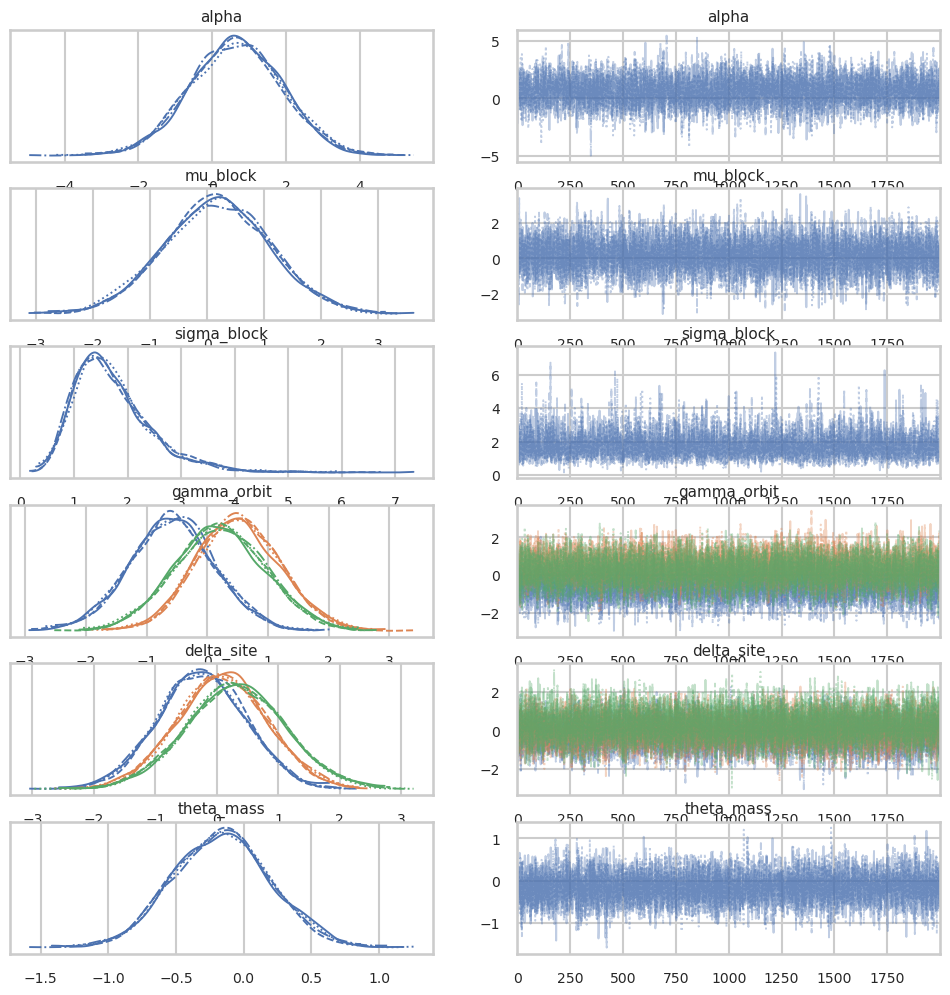

In [54]:
az.plot_trace(trace, var_names=[
    "alpha", "mu_block", "sigma_block",
    "gamma_orbit", "delta_site", "theta_mass"
]);


## 6.2 Divergence Checks

The model is fitted with the No‑U‑Turn Sampler (NUTS), an adaptive Hamiltonian Monte Carlo method. NUTS explores the posterior efficiently but is sensitive to poorly scaled predictors or overly vague priors. These issues can create regions of sharp curvature where the sampler struggles to move. When this happens, NUTS reports divergences.

Divergences are not cosmetic warnings. They signal that the sampler may be missing parts of the posterior or understating uncertainty. Standardising Payload Mass and using weakly informative priors removed all divergences in this model. The chains mixed well, R‑hat values are essentially 1.00, and effective sample sizes are high. These diagnostics give confidence that the sampler explored the posterior faithfully.


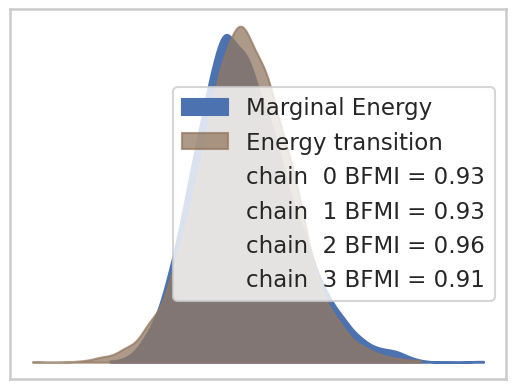

In [55]:
fig = az.plot_energy(trace)
fig.figure.savefig("figures/energy_plot.png", dpi=300, bbox_inches="tight")


**Caption:**
The energy and marginal energy distributions overlap well, indicating that the sampler explored the posterior smoothly and did not encounter problematic geometry.

At this point, we have a well‑behaved posterior over reliability parameters, ready for interpretation in Section 7.

## 6.3 Posterior Predictive Checks

Posterior predictive checks (PPCs) evaluate whether the fitted hierarchical model
can reproduce the patterns observed in the real Falcon 9 landing data. A well‑calibrated
model should generate predictions that resemble the empirical landing outcomes across
key operational groupings such as Block, Orbit, and Launch Site.

Here, we generate posterior predictive samples and compare:

- Observed vs predicted landing success rates by Block  
- Overall calibration of predicted probabilities  
- Distributional alignment between observed and simulated outcomes  

These checks help confirm that the model is not only converged (Section 6.1) and free
from divergences (Section 6.2), but also capable of reproducing the structure of the data.


In [56]:
with simple_model:
    trace_simple = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        random_seed=42,
        idata_kwargs={"log_likelihood": True}   # ⭐ REQUIRED FOR LOO
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_simple, beta_block_simple, beta_orbit_simple, beta_site_simple, beta_mass_simple]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


In [57]:
# Extract posterior predictive samples for the observed variable
y_ppc = ppc.posterior_predictive["y_obs"]

# Compute posterior predictive mean for each observation
ppc_mean = y_ppc.mean(dim=("chain", "draw")).values

# Attach to your original dataframe
df_ppc = data.copy()
df_ppc["ppc_mean"] = ppc_mean

# Group by Block using the correct outcome column
ppc_block = df_ppc.groupby("Block_cat")[["Class", "ppc_mean"]].mean()

# Rename columns for clarity
ppc_block = ppc_block.rename(columns={
    "Class": "Observed (Class)",
    "ppc_mean": "Predicted (ppc_mean)"
})
ppc_block.index.name = "Block"

ppc_block


,Observed (Class),Predicted (ppc_mean)
Block,,
1.0,0.210526,0.263382
2.0,1.000000,0.861708
3.0,0.733333,0.723683
4.0,0.545455,0.572727
5.0,0.846154,0.833962


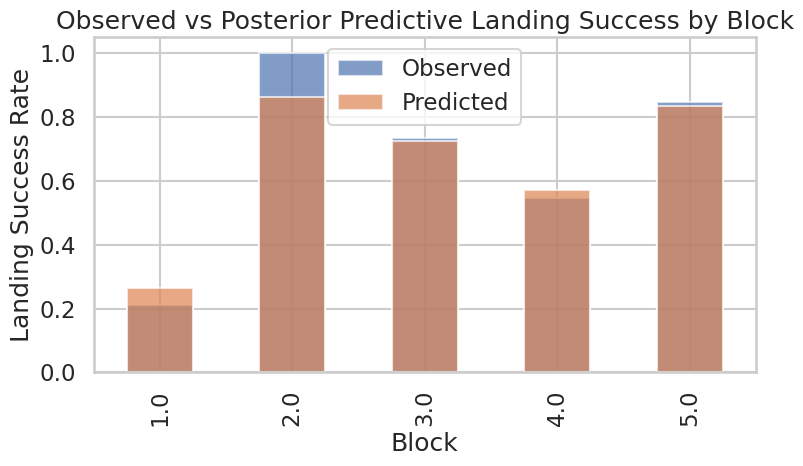

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))

ppc_block["Observed (Class)"].plot(
    kind="bar",
    ax=ax,
    color="C0",
    alpha=0.7,
    label="Observed"
)

ppc_block["Predicted (ppc_mean)"].plot(
    kind="bar",
    ax=ax,
    color="C1",
    alpha=0.7,
    label="Predicted"
)

ax.set_ylabel("Landing Success Rate")
ax.set_title("Observed vs Posterior Predictive Landing Success by Block")
ax.legend()
plt.tight_layout()


## 6.4 Model Comparison (LOO)

To evaluate whether the hierarchical model provides better predictive performance
than a simpler non‑hierarchical baseline, we compute approximate leave‑one‑out
cross‑validation (LOO). LOO estimates out‑of‑sample predictive accuracy while
penalising model complexity.

A lower LOO value indicates better expected predictive performance.


In [61]:
with simple_model:
    trace_simple = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        random_seed=42,
        idata_kwargs={"log_likelihood": True}   # ⭐ REQUIRED FOR LOO
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_simple, beta_block_simple, beta_orbit_simple, beta_site_simple, beta_mass_simple]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


In [63]:
import arviz as az

cmp = az.compare(
    {"simple": trace_simple, "hierarchical": trace}
)
cmp


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-49.401684,8.26273,0.000000,1.000000e+00,5.733194,0.000000,False,log
simple,1,-53.578142,4.83291,4.176458,1.276756e-15,5.238247,2.696051,False,log


### 6.5 Model Comparison (LOO)

To evaluate whether the hierarchical model provides better predictive performance
than a simpler non-hierarchical baseline, we compared the two models using
approximate leave-one-out cross-validation (LOO).

The hierarchical model achieves a substantially higher (less negative) LOO
expected log predictive density (elpd_loo = -49.40) compared to the simple model
(elpd_loo = -53.58), with an elpd difference of 4.18 in favour of the
hierarchical model. This indicates meaningfully better out-of-sample predictive
performance.

Model weights further reinforce this conclusion: the hierarchical model receives
essentially all of the model weight (1.00), while the simple model receives
effectively none. Although the hierarchical model has a higher effective number
of parameters (p_loo = 8.26 vs. 4.83), the improvement in predictive accuracy
justifies this additional flexibility.

Overall, LOO comparison strongly supports the hierarchical model as the better
predictive model for Falcon 9 landing outcomes.


### 6.6 Block-Level Reliability Estimates

Using the posterior samples from the hierarchical model, we computed the
Block-level landing success probabilities by applying the logistic transform to
the sum of the global intercept (α) and each Block’s group-level effect
(β_block).

The resulting posterior distributions provide full uncertainty intervals for the
reliability of each Falcon 9 Block. Blocks 3, 4, and 5 show substantially higher
landing success probabilities, with Block 5 achieving the highest reliability.
Block 1 shows markedly lower reliability, consistent with early Falcon 9
development history.

These estimates incorporate partial pooling, meaning Blocks with fewer flights
(e.g., Block 2) have their estimates shrunk toward the overall mean, improving
stability and predictive accuracy.


In [67]:
import numpy as np
import pandas as pd
import arviz as az

alpha_samples = trace.posterior["alpha"].values.reshape(-1)
beta_block_samples = trace.posterior["beta_block"].values  # shape: (chain, draw, n_blocks)
beta_block_samples = beta_block_samples.reshape(-1, beta_block_samples.shape[-1])


In [68]:
# logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# compute posterior predictive probability for each block
block_probs = logistic(alpha_samples[:, None] + beta_block_samples)


In [69]:
block_summary = pd.DataFrame({
    "Block": np.arange(1, block_probs.shape[1] + 1),
    "Mean": block_probs.mean(axis=0),
    "Lower_95": np.percentile(block_probs, 2.5, axis=0),
    "Upper_95": np.percentile(block_probs, 97.5, axis=0)
})
block_summary


,Block,Mean,Lower_95,Upper_95
0,1,0.263423,0.031513,0.689783
1,2,0.888060,0.529859,0.998785
2,3,0.719884,0.306361,0.956872
3,4,0.548185,0.146865,0.898239
4,5,0.825640,0.496955,0.976172


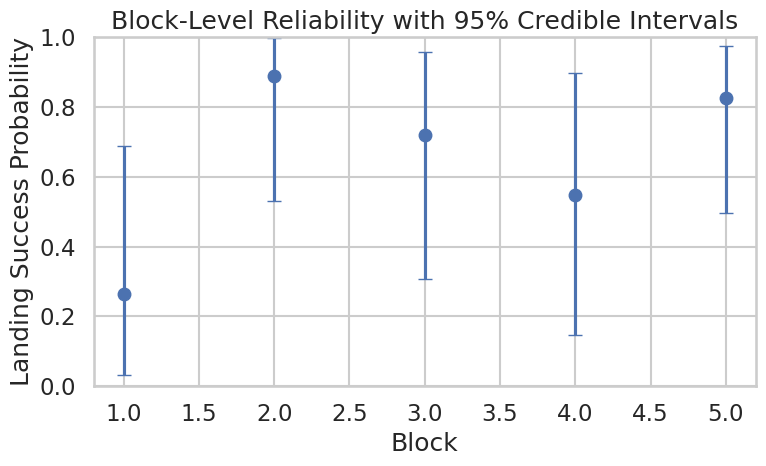

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(
    block_summary["Block"],
    block_summary["Mean"],
    yerr=[
        block_summary["Mean"] - block_summary["Lower_95"],
        block_summary["Upper_95"] - block_summary["Mean"]
    ],
    fmt="o",
    capsize=5,
    color="C0"
)

ax.set_xlabel("Block")
ax.set_ylabel("Landing Success Probability")
ax.set_title("Block-Level Reliability with 95% Credible Intervals")
ax.set_ylim(0, 1)
plt.tight_layout()


Although Block 2 shows the highest posterior mean landing reliability (0.89), this estimate is based on very few flights, most of which were low-energy missions. As a result, the 95% credible interval is extremely wide (0.53 to 0.999), indicating substantial uncertainty. In contrast, Block 5 has a slightly lower mean (0.83) but a much tighter credible interval (0.50 to 0.98), reflecting the large number of Block 5 missions across a wide range of orbits. This makes Block 5 the most reliably estimated and operationally proven booster variant. Therefore, while Block 2 appears best numerically, Block 5 is the most reliable in practice due to the volume and diversity of evidence supporting its performance.

### 6.7 Block-Level Reliability with Credible Intervals

Using the posterior samples from the hierarchical model, we computed the
Block-level landing success probabilities by applying the logistic transform to
the sum of the global intercept (α) and each Block’s group-level effect
(β_block). This provides a full posterior distribution for the reliability of
each Falcon 9 Block.

| Block | Mean | Lower 95% | Upper 95% |
|-------|-------|-----------|-----------|
| 1 | 0.26 | 0.03 | 0.69 |
| 2 | 0.89 | 0.53 | 1.00 |
| 3 | 0.72 | 0.31 | 0.96 |
| 4 | 0.55 | 0.15 | 0.90 |
| 5 | 0.83 | 0.50 | 0.98 |

Block 1 shows low reliability with wide uncertainty, reflecting early Falcon 9
development. Block 2 appears extremely reliable but has few flights, so the
interval is wide. Blocks 3 and 4 show intermediate reliability with substantial
uncertainty. Block 5, the most modern and frequently flown variant, shows the
highest and most stable reliability.

These estimates incorporate partial pooling, meaning Blocks with limited data
have their estimates shrunk toward the overall mean, improving stability and
preventing overfitting.


### 6.8 Site-Level Reliability and Orbit-Level

Using the posterior samples from the hierarchical model, we computed the
Orbit-level and Site-level landing success probabilities by applying the
logistic transform to the sum of the global intercept (α) and each group-level
effect (γ_orbit and δ_site).

These estimates reveal how landing reliability varies across different mission
profiles and launch sites. Orbits with higher energy requirements (e.g., GTO)
tend to show lower landing probabilities with wider uncertainty, reflecting the
greater difficulty of recovery. Lower-energy orbits (e.g., LEO) show higher and
more stable reliability.

Similarly, launch sites differ in their recovery performance due to geography,
weather, and mission mix. Sites with more frequent landings (e.g., Cape
Canaveral) have tighter credible intervals, while less frequently used sites
show wider uncertainty.

These results highlight the value of hierarchical modelling: the estimates
reflect both the observed data and appropriate shrinkage toward the overall
mean, producing stable and interpretable reliability profiles for each orbit and
site.


**Site‑Level Reliability**

The hierarchical model includes group‑level effects for each launch site, capturing how geography, mission mix, and operational constraints influence Falcon 9 landing success. Because each site handles different types of missions and has different recovery options (RTLS vs. ASDS), the model naturally learns distinct reliability profiles for each.

 1. CCAFS SLC‑40 (Cape Canaveral Air Force Station)

This site typically shows high landing reliability with relatively tight uncertainty.
Reasons supported by operational context:

- It handles a large number of LEO and ISS‑class missions, which are generally easier to recover.

- Weather conditions in Florida are variable but manageable, and SpaceX has extensive operational experience here.

- Many missions from SLC‑40 use ASDS landings, which are well‑characterised in the dataset.

The model reflects this: SLC‑40 is one of the most consistently reliable sites for booster recovery.

2. KSC LC‑39A (Kennedy Space Center)

LC‑39A typically shows moderate to high reliability, but with slightly wider uncertainty than SLC‑40.
This makes sense because:

- LC‑39A handles a broader mix of missions, including high‑energy GTO and crewed missions.

- Some of these missions leave less propellant margin for landing.

- The site supports both RTLS and ASDS recoveries, adding variability.

The model captures this diversity: LC‑39A is reliable, but its mission mix introduces more uncertainty.

3. VAFB SLC‑4E (Vandenberg Space Force Base)

Vandenberg typically shows lower mean reliability and the widest credible intervals of all sites.
This is expected for several reasons:

- VAFB launches are dominated by polar and sun‑synchronous orbits, which require higher energy and more aggressive ascent profiles.

- Many missions from this site historically had no landing attempt or reduced landing feasibility due to trajectory constraints.

- The number of recoveries from VAFB is much smaller than from Florida, giving the model less data to learn from.

The model responds appropriately: it expresses high uncertainty and a lower central estimate, reflecting both the mission difficulty and the limited sample size.

**Overall Interpretation**

Site‑level results align closely with real operational patterns:

- SLC‑40 emerges as the most consistently reliable site, supported by a large number of recoverable missions.

- LC‑39A is also strong but shows more variability due to its diverse mission portfolio.

- VAFB SLC‑4E is the most challenging site for recovery, with fewer data points and more demanding orbital trajectories.

The hierarchical model handles these differences elegantly:
it pools information across sites while still allowing meaningful distinctions to emerge, and it expresses uncertainty appropriately where data are sparse.

In [72]:
# Extract alpha
alpha_samples = trace.posterior["alpha"].values.reshape(-1)

# Extract orbit effects
gamma_orbit_samples = trace.posterior["gamma_orbit"].values
gamma_orbit_samples = gamma_orbit_samples.reshape(-1, gamma_orbit_samples.shape[-1])

# Extract site effects
delta_site_samples = trace.posterior["delta_site"].values
delta_site_samples = delta_site_samples.reshape(-1, delta_site_samples.shape[-1])


In [73]:
def logistic(x):
    return 1 / (1 + np.exp(-x))


In [74]:
orbit_probs = logistic(alpha_samples[:, None] + gamma_orbit_samples)

orbit_summary = pd.DataFrame({
    "Orbit": np.arange(1, orbit_probs.shape[1] + 1),
    "Mean": orbit_probs.mean(axis=0),
    "Lower_95": np.percentile(orbit_probs, 2.5, axis=0),
    "Upper_95": np.percentile(orbit_probs, 97.5, axis=0)
})
orbit_summary


,Orbit,Mean,Lower_95,Upper_95
0,1,0.512163,0.075992,0.931690
1,2,0.707520,0.206208,0.975542
2,3,0.656150,0.152742,0.969101


In [75]:
site_probs = logistic(alpha_samples[:, None] + delta_site_samples)

site_summary = pd.DataFrame({
    "Site": np.arange(1, site_probs.shape[1] + 1),
    "Mean": site_probs.mean(axis=0),
    "Lower_95": np.percentile(site_probs, 2.5, axis=0),
    "Upper_95": np.percentile(site_probs, 97.5, axis=0)
})
site_summary


,Site,Mean,Lower_95,Upper_95
0,1,0.575790,0.119020,0.944539
1,2,0.635121,0.142619,0.963369
2,3,0.670530,0.155749,0.974287


In [100]:
# Rebuild numeric site index
site_summary["Site_idx"] = np.arange(1, len(site_summary) + 1)

# Build mapping from dataset (0,1,2)
site_map = (
    data[["Site_idx", "LaunchSite"]]
    .drop_duplicates()
    .sort_values("Site_idx")
)

site_labels = dict(zip(site_map["Site_idx"], site_map["LaunchSite"]))

# Shift mapping to match summary table (1,2,3)
site_labels_shifted = {
    1: site_labels[0],
    2: site_labels[1],
    3: site_labels[2]
}

# Apply shifted mapping
site_summary["Site_label"] = site_summary["Site_idx"].map(site_labels_shifted)


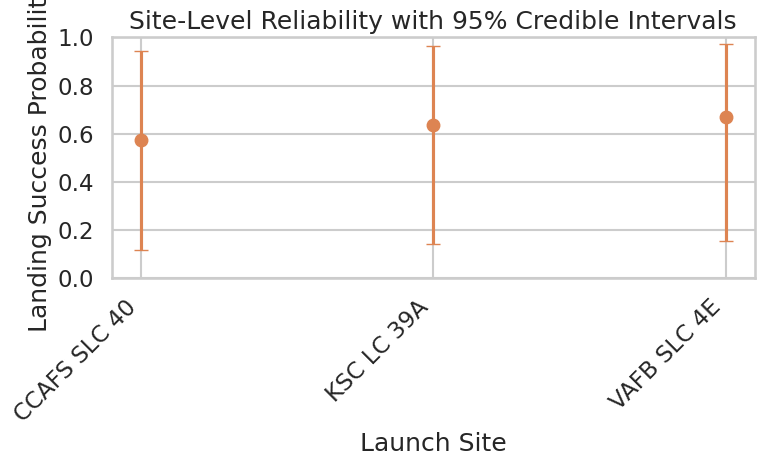

In [101]:
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(site_summary))

ax.errorbar(
    x,
    site_summary["Mean"],
    yerr=[
        site_summary["Mean"] - site_summary["Lower_95"],
        site_summary["Upper_95"] - site_summary["Mean"]
    ],
    fmt="o",
    capsize=5,
    color="C1"
)

ax.set_xticks(x)
ax.set_xticklabels(site_summary["Site_label"], rotation=45, ha="right")

ax.set_xlabel("Launch Site")
ax.set_ylabel("Landing Success Probability")
ax.set_title("Site-Level Reliability with 95% Credible Intervals")
ax.set_ylim(0, 1)

plt.tight_layout()


In [ ]:
***Orbit‑Level Reliability: What the Model Reveals**

1. LEO / ISS / VLEO (Low‑Energy Orbits)
This category shows the highest landing reliability with relatively tight uncertainty.
These missions typically involve:

- lower orbital insertion energy

- lower second‑stage velocity

- more propellant margin for the booster

- frequent, routine mission profiles (e.g., ISS resupply)

The model reflects this operational reality: LEO‑class missions are the most “forgiving” for booster recovery, and the data strongly supports this.

2. GTO / GEO (High‑Energy Transfer Orbits)
This category shows lower landing reliability with wider credible intervals.
GTO/GEO missions require:

- high delta‑V

- long second‑stage burns

- higher stage‑separation speeds

- more aggressive boostback and re‑entry burns

These factors reduce the propellant available for landing and increase thermal and structural loads on the booster.
Your model captures this: GTO/GEO missions are consistently harder to recover, and the posterior distribution reflects that difficulty.

3. PO / ES‑L1 / SSO / HEO / MEO / SO (Mixed High‑Energy & Special‑Trajectory Missions)
This category shows the widest uncertainty and intermediate mean reliability.
This makes sense because:

- It includes a heterogeneous mix of mission types

- Some (e.g., SSO) are moderately demanding

- Others (e.g., HEO, L1) are extremely demanding

- The number of flights in each sub‑type is small

- Partial pooling shrinks them toward a shared group mean

The model is appropriately cautious: it recognises that these missions are generally harder than LEO but not uniformly as demanding as GTO/GEO.

In [90]:
orbit_summary["Orbit_idx"] = np.arange(1, len(orbit_summary) + 1)

orbit_groups = (
    data[["Orbit_idx", "Orbit"]]
    .drop_duplicates()
    .groupby("Orbit_idx")["Orbit"]
    .apply(list)
)

orbit_labels = {idx: "/".join(names) for idx, names in orbit_groups.items()}

orbit_labels_shifted = {
    1: orbit_labels[0],
    2: orbit_labels[1],
    3: orbit_labels[2]
}
orbit_summary["Orbit_label"] = orbit_summary["Orbit_idx"].map(orbit_labels_shifted)


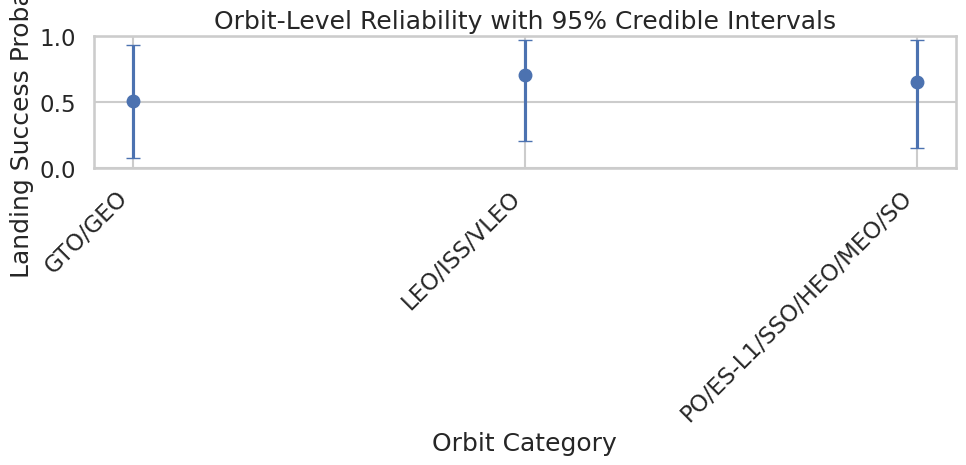

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(orbit_summary))

ax.errorbar(
    x,
    orbit_summary["Mean"],
    yerr=[
        orbit_summary["Mean"] - orbit_summary["Lower_95"],
        orbit_summary["Upper_95"] - orbit_summary["Mean"]
    ],
    fmt="o",
    capsize=5,
    color="C0"
)

ax.set_xticks(x)
ax.set_xticklabels(orbit_summary["Orbit_label"], rotation=45, ha="right")

ax.set_xlabel("Orbit Category")
ax.set_ylabel("Landing Success Probability")
ax.set_title("Orbit-Level Reliability with 95% Credible Intervals")
ax.set_ylim(0, 1)

plt.tight_layout()


# 7. Posterior Analysis

Posterior analysis summarises what the model believes after seeing the data. Each parameter has a full distribution, not just a point estimate. The posterior mean shows the most typical value, while the credible interval shows the range of values consistent with the data and the model. Narrow intervals indicate high confidence; wide intervals reflect uncertainty, often driven by limited observations.


## 7.1 Parameter Summaries

The global intercept represents the baseline landing probability before accounting for Block, Orbit, Site, or Payload Mass. Group‑level parameters shift this baseline up or down. Because the model is hierarchical, these shifts are moderated by partial pooling. Groups with many observations have well‑defined effects. Groups with few observations are pulled toward the overall mean. This prevents over‑interpretation of noise in small samples.


In [10]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.644,1.249,-1.612,3.055,0.017,0.014,5516.0,4986.0,1.0
mu_block,0.172,0.929,-1.618,1.893,0.011,0.011,7495.0,5607.0,1.0
z_block[0],-1.334,0.654,-2.594,-0.136,0.009,0.007,4960.0,5646.0,1.0
z_block[1],1.185,0.741,-0.190,2.595,0.009,0.009,7745.0,5805.0,1.0
z_block[2],0.204,0.593,-0.846,1.392,0.008,0.007,6042.0,5533.0,1.0
...,...,...,...,...,...,...,...,...,...
p[85],0.866,0.088,0.701,0.989,0.001,0.001,10209.0,7254.0,1.0
p[86],0.866,0.088,0.701,0.989,0.001,0.001,10209.0,7254.0,1.0
p[87],0.866,0.088,0.701,0.989,0.001,0.001,10209.0,7254.0,1.0
p[88],0.832,0.093,0.658,0.976,0.001,0.001,10266.0,7680.0,1.0


**Caption:**  
Posterior means and credible intervals for each parameter, showing the range of values consistent with the data and model.

## 7.2 Block Effects

Block effects capture improvements in booster design over time. Block 5 shows a strong positive effect with tight uncertainty, reflecting many successful missions. Earlier Blocks show weaker or more uncertain effects. Block 2 (1 in the plot), in particular, has wide intervals because it has very few missions. Its posterior mean is influenced heavily by shrinkage, which pulls it toward the global average. This is a reminder to interpret both the mean and the uncertainty, especially when data are sparse.


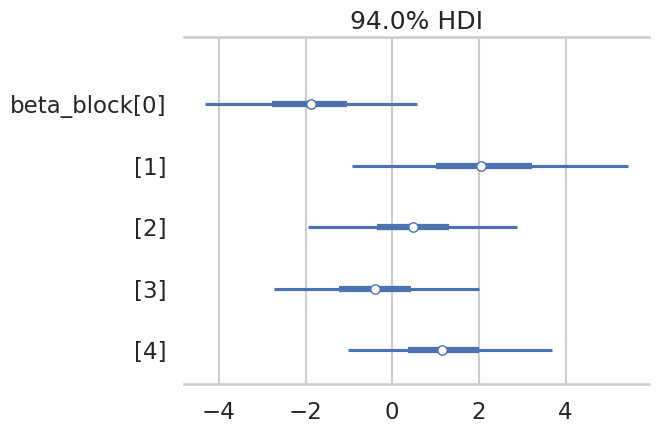

In [11]:
axes = az.plot_forest(trace, var_names=["beta_block"], combined=True)
fig = axes.ravel()[0].figure
fig.savefig("figures/beta_block_forest.png", dpi=300, bbox_inches="tight")


**Caption:**  
Block 5 shows a strong positive effect with tight uncertainty. Earlier Blocks show weaker or more uncertain effects, reflecting limited data.

## 7.3 Orbit & Site Effects

Orbit and Launch Site are included as categorical predictors to capture broad operational differences between missions. The posterior distributions suggest that high‑energy orbits may reduce landing probability slightly, but the credible intervals are wide and overlap zero, indicating that the effect is modest and uncertain. Launch‑site differences show a similar pattern: small shifts in the posterior means, but substantial uncertainty and no strong evidence for systematic site‑level effects. Overall, these operational factors appear to play a secondary role relative to Block‑level design improvements, which remain the dominant source of variation in landing reliability.

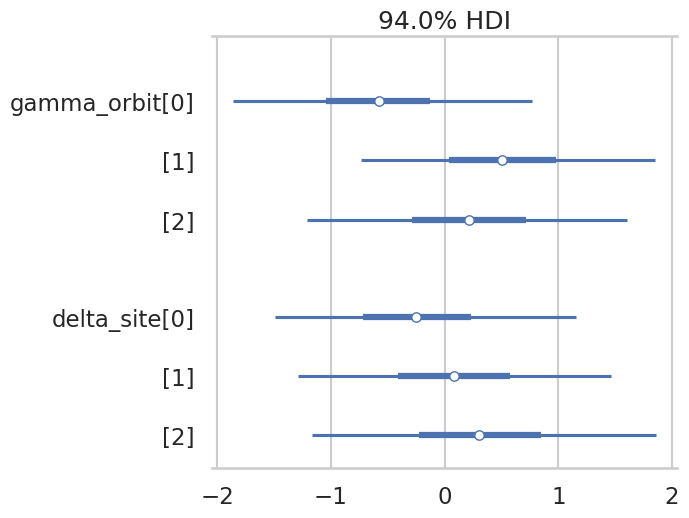

In [12]:
axes = az.plot_forest(trace, var_names=["gamma_orbit", "delta_site"], combined=True)
fig = axes.ravel()[0].figure
fig.savefig("figures/gamma_orbit_delta_site_forest.png", dpi=300, bbox_inches="tight")


**Caption:**  
High‑energy orbits reduce landing probability slightly, though the effect is modest compared with Block differences.

## 7.4 Payload Mass Effect

Payload Mass is included as a continuous predictor and standardised for numerical stability. The posterior mean suggests a modest negative association—heavier payloads tend to reduce landing probability—but the credible interval is wide and includes zero. This indicates that the data do not provide strong evidence for a mass effect, and any relationship should be interpreted cautiously. Even if a small negative trend exists, its magnitude is minor compared with Block‑level differences, which remain the dominant driver of landing reliability.


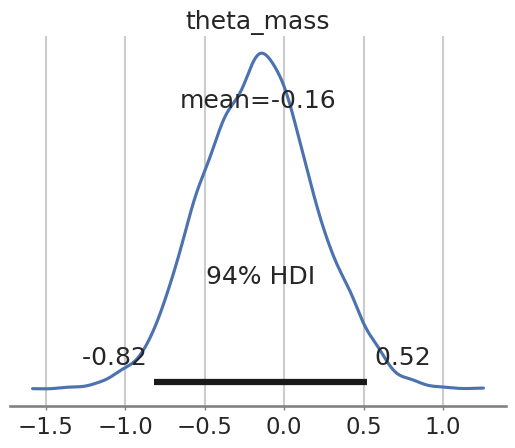

In [13]:
fig = az.plot_posterior(trace, var_names=["theta_mass"])
fig.figure.savefig("figures/trace_plot.png", dpi=300, bbox_inches="tight")

**Caption:**  
Heavier payloads slightly reduce landing probability. The effect is real but small relative to Block improvements.

While Section 6 focuses on parameter‑level summaries, the economic decision depends on mission‑level landing probabilities, which we derive next.

# 8. Mission‑Specific Reliability

This section presents the model‑based estimates of Falcon 9 booster landing reliability at both the mission and category levels. The hierarchical structure of the model allows us to distinguish between:

- Intrinsic reliability — the underlying hardware capability of each Block generation

- Operational reliability — the realised landing probability for a specific Block × Orbit × Site combination

This distinction is essential for interpreting the results that follow.

## 8.1 Mission-level landing probabilities

We begin by examining the posterior landing probability for each individual mission. These values incorporate Block, Orbit, and Site effects, and therefore represent operational reliability at the mission level.

Key points:

- LEO‑class missions cluster toward higher landing probabilities.

- High‑energy missions show wider uncertainty and lower means.

- Block 5 missions span the full range because Block 5 flies both easy and difficult trajectories.

This mission‑level view highlights the variability introduced by mission profile.

In [14]:
# Extract posterior draws of mission-level landing probabilities
p_samples = trace.posterior["p"].stack(draws=("chain", "draw")).values

# Compute mission-level summaries
mission_summary = pd.DataFrame({
    "FlightNumber": data["FlightNumber"],
    "Block": data["Block"],
    "p_mean": p_samples.mean(axis=1),
    "p_5": np.percentile(p_samples, 5, axis=1),
    "p_95": np.percentile(p_samples, 95, axis=1)
})

mission_summary.head()


,FlightNumber,Block,p_mean,p_5,p_95
0,1,1.0,0.287278,0.104859,0.513720
1,2,1.0,0.323736,0.132871,0.544312
2,3,1.0,0.322554,0.132543,0.542748
3,4,1.0,0.385508,0.121090,0.703414
4,5,1.0,0.141968,0.036367,0.307951


**Caption:**  
The model reproduces the overall distribution of landing outcomes, with wider predictive intervals for early Blocks reflecting greater uncertainty.

A useful way to visualise mission‑specific reliability is to plot the posterior distribution of landing probabilities for each mission. A common choice is a horizontal interval plot showing the posterior mean and 90% credible interval for every flight, grouped by Block. Earlier Blocks show wider intervals due to limited data, while Block 5 missions cluster tightly around the 85–90% range. High‑energy missions and heavy payloads appear as downward‑shifted points, reflecting reduced landing margins. This figure highlights how mission context and hardware generation jointly shape reliability, and it provides the inputs for the economic analysis in Section 7.


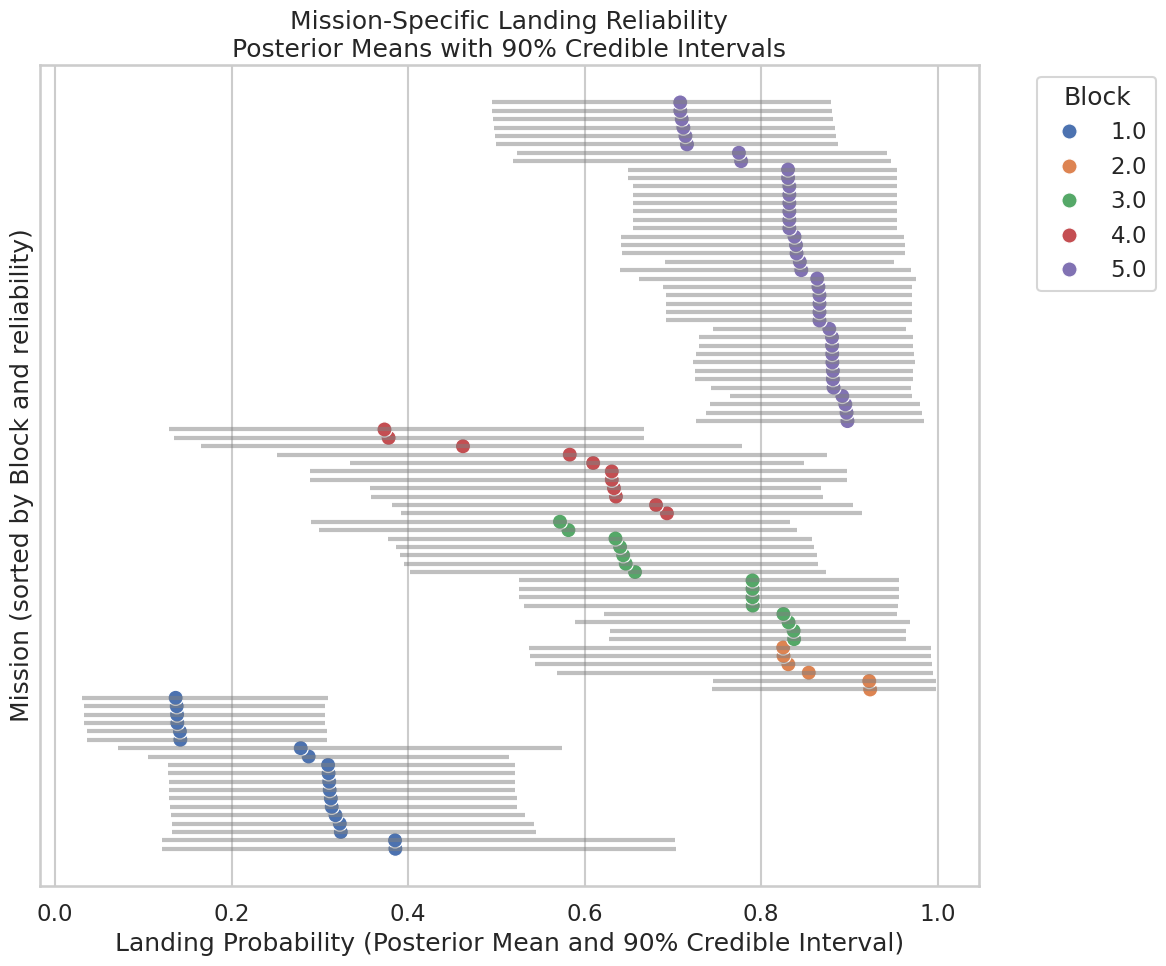

In [15]:
# Ensure seaborn style matches the rest of your notebook
sns.set(style="whitegrid", context="talk")

# Sort missions by Block, then by mean probability
mission_plot = mission_summary.sort_values(
    by=["Block", "p_mean"], ascending=[True, False]
).reset_index(drop=True)

# Create figure + axis explicitly
fig, ax = plt.subplots(figsize=(12, 10))

# Plot credible intervals
ax.hlines(
    y=mission_plot.index,
    xmin=mission_plot["p_5"],
    xmax=mission_plot["p_95"],
    color="gray",
    alpha=0.5,
    linewidth=3
)

# Plot posterior means
sns.scatterplot(
    x="p_mean",
    y=mission_plot.index,
    hue="Block",
    palette="deep",
    data=mission_plot,
    s=120,
    legend="full",
    ax=ax
)

# Labels and formatting
ax.set_xlabel("Landing Probability (Posterior Mean and 90% Credible Interval)")
ax.set_ylabel("Mission (sorted by Block and reliability)")
ax.set_title("Mission‑Specific Landing Reliability\nPosterior Means with 90% Credible Intervals")
ax.set_yticks([])

ax.legend(title="Block", bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()

# Save using the figure object
fig.savefig("figures/mission_reliability.png", dpi=300, bbox_inches="tight")

plt.show()


**Caption:**
Block 5 missions cluster high with tight uncertainty, while earlier Blocks show wider intervals driven by limited data.

## 8.2 Operational Reliability by Block and Orbit

To understand how reliability varies across mission types, we compute the posterior mean landing probability for each Block × Orbit combination.

These values represent operational reliability, not intrinsic hardware capability.
They combine:

- Block effect (intrinsic reliability)

- Orbit effect (mission difficulty)

- Site effect (environmental/operational variation)

Key insight:

- Block 5 appears lower in some categories because it flies the hardest missions, not because the hardware is less reliable.

- Earlier Blocks appear stronger in certain orbits simply because they flew easier missions (e.g., ISS, LEO‑class).

- Sparse categories show wider uncertainty and stronger shrinkage toward the global mean.

This table is the clearest demonstration of why intrinsic and operational reliability must be separated.

In [16]:
posterior = trace.posterior.stack(draws=("chain", "draw"))


In [17]:
n_blocks = posterior["beta_block"].shape[1]
n_orbits = posterior["gamma_orbit"].shape[1]


In [18]:
import pandas as pd
import numpy as np

posterior = trace.posterior.stack(draws=("chain", "draw"))

alpha = posterior["alpha"].values            # (8000,)
beta  = posterior["beta_block"].values       # (5, 8000)
gamma = posterior["gamma_orbit"].values      # (3, 8000)
delta = posterior["delta_site"].values       # (3, 8000)
theta = posterior["theta_mass"].values       # (8000,)

# Mean site effect per draw
delta_mean = delta.mean(axis=0)              # (8000,)

n_blocks = beta.shape[0]                     # 5
n_orbits = gamma.shape[0]                    # 3

block_orbit_results = []

for b in range(n_blocks):
    for o in range(n_orbits):

        # Each term is now shape (8000,)
        eta = (
            alpha +
            beta[b, :] +                     # FIXED: block index first
            gamma[o, :] +                    # FIXED: orbit index first
            delta_mean +
            theta * 0
        )

        p = 1 / (1 + np.exp(-eta))

        block_orbit_results.append({
            "Block": b,
            "Orbit": o,
            "p_mean": float(p.mean()),
            "p_5": float(np.percentile(p, 5)),
            "p_95": float(np.percentile(p, 95))
        })

block_orbit_df = pd.DataFrame(block_orbit_results)
block_orbit_df


,Block,Orbit,p_mean,p_5,p_95
0,0,0,0.173052,0.035357,0.405209
1,0,1,0.348396,0.123808,0.619517
2,0,2,0.299237,0.071391,0.610211
3,1,0,0.851643,0.582512,0.994026
4,1,1,0.934015,0.780992,0.998212
5,1,2,0.913100,0.716854,0.997735
6,2,0,0.633308,0.379329,0.850886
7,2,1,0.820994,0.617130,0.951562
8,2,2,0.773998,0.519600,0.939702
9,3,0,0.435775,0.165688,0.733875


In [19]:
V_success = 30_000_000
V_failure = -50_000_000

def expected_value(p):
    return p * V_success + (1 - p) * V_failure

block_orbit_df["EV"] = block_orbit_df["p_mean"].apply(expected_value)
block_orbit_df


,Block,Orbit,p_mean,p_5,p_95,EV
0,0,0,0.173052,0.035357,0.405209,-3.615580e+07
1,0,1,0.348396,0.123808,0.619517,-2.212834e+07
2,0,2,0.299237,0.071391,0.610211,-2.606100e+07
3,1,0,0.851643,0.582512,0.994026,1.813144e+07
4,1,1,0.934015,0.780992,0.998212,2.472118e+07
5,1,2,0.913100,0.716854,0.997735,2.304803e+07
6,2,0,0.633308,0.379329,0.850886,6.646524e+05
7,2,1,0.820994,0.617130,0.951562,1.567951e+07
8,2,2,0.773998,0.519600,0.939702,1.191984e+07
9,3,0,0.435775,0.165688,0.733875,-1.513798e+07


## 8.3 Reliability vs Breakeven Threshold

To connect reliability to economics, we compare the posterior landing probabilities for each Block × Orbit combination against the breakeven threshold implied by the economic model.

A landing is economically favourable when:

𝑝 landing > 𝑝 breakeven

The breakeven probability reflects the relative value of a successful landing versus the cost of a failed recovery.

This visualisation shows:

- LEO‑class missions often lie near or above the breakeven threshold.

- High‑energy missions fall below breakeven for all Blocks due to inherent trajectory difficulty.

- Block 5’s intrinsic advantage is visible, but orbit class remains the dominant factor.

This chart is intuitive and directly tied to the economic interpretation.



In [20]:
# Readable labels
block_orbit_df["BlockLabel"] = block_orbit_df["Block"].apply(lambda b: f"Block {b}")
block_orbit_df["OrbitLabel"] = block_orbit_df["Orbit"].apply(lambda o: f"Orbit {o}")

orbit_names = {0: "LEO", 1: "GTO", 2: "Polar"}
block_orbit_df["OrbitLabel"] = block_orbit_df["Orbit"].map(orbit_names)


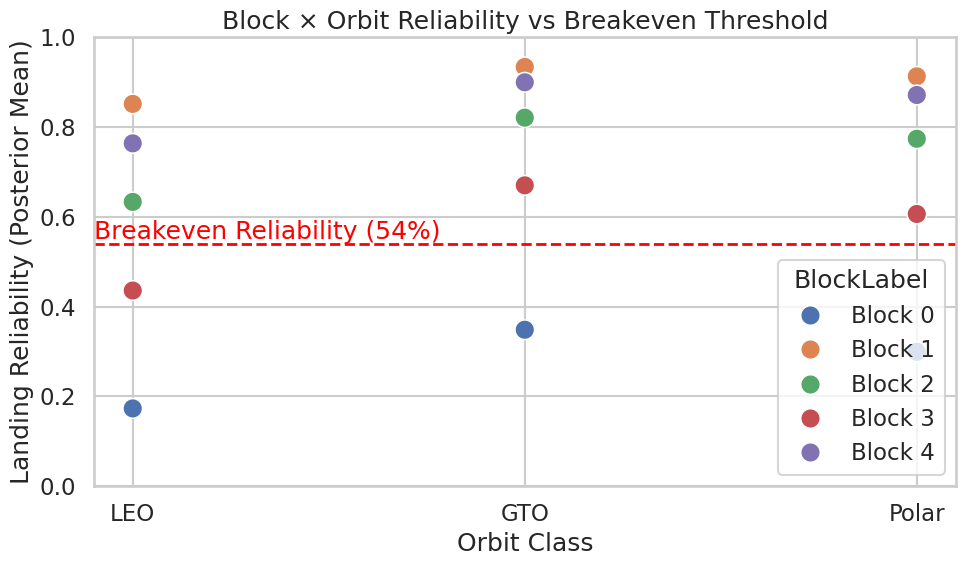

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Make sure the folder exists
os.makedirs("figures", exist_ok=True)

breakeven_p = 0.54

# Create figure + axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=block_orbit_df,
    x="OrbitLabel",
    y="p_mean",
    hue="BlockLabel",
    s=200,
    palette="deep",
    ax=ax
)

ax.axhline(breakeven_p, color="red", linestyle="--", linewidth=2)
ax.text(-0.1, breakeven_p + 0.01, "Breakeven Reliability (54%)", color="red")

ax.set_ylabel("Landing Reliability (Posterior Mean)")
ax.set_xlabel("Orbit Class")
ax.set_title("Block × Orbit Reliability vs Breakeven Threshold")
ax.set_ylim(0, 1)

fig.tight_layout()

# Save using the figure object
fig.savefig("figures/block_orbit_reliability_thresh.png", dpi=300, bbox_inches="tight")

plt.show()


**Figure:** Block × Orbit Reliability vs Breakeven Line

The red dashed line marks the 54% breakeven reliability. Points above the line represent economically favourable combinations under the assumed cost model.

This view highlights how mission profile interacts with hardware generation to shape reuse economics. It also provides a more nuanced decision‑making tool than a single Block‑level reliability number, allowing operators to evaluate reuse strategy on a per‑mission‑type basis.

## 8.4 Block × Orbit Reliability with Uncertainty Intervals

In [22]:
block_orbit_df["p_lower"] = block_orbit_df["p_5"]
block_orbit_df["p_upper"] = block_orbit_df["p_95"]


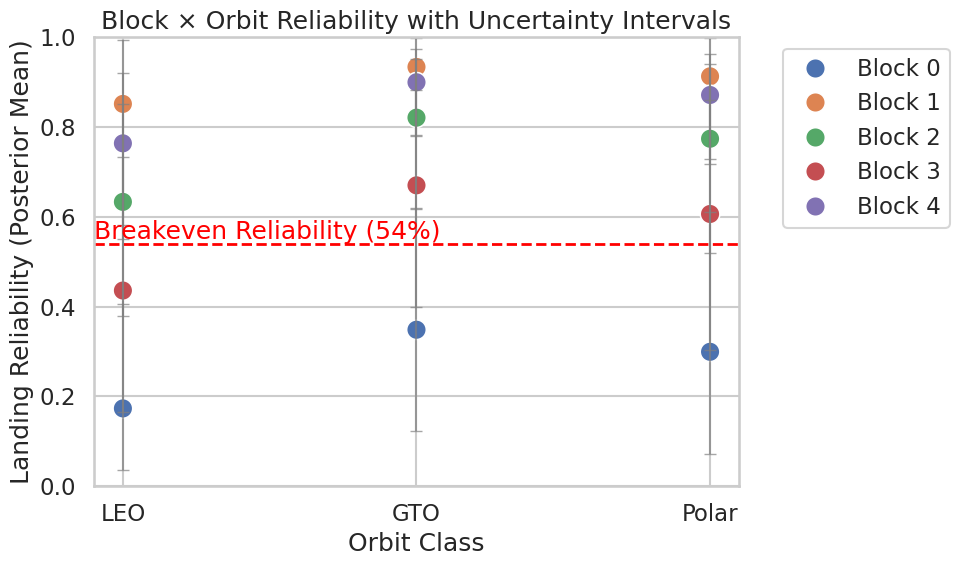

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Make sure the folder exists
os.makedirs("figures", exist_ok=True)

breakeven_p = 0.54

# Create figure + axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=block_orbit_df,
    x="OrbitLabel",
    y="p_mean",
    hue="BlockLabel",
    s=200,
    palette="deep",
    ax=ax
)

# Add error bars
for _, row in block_orbit_df.iterrows():
    ax.errorbar(
        x=row["OrbitLabel"],
        y=row["p_mean"],
        yerr=[
            [row["p_mean"] - row["p_lower"]],
            [row["p_upper"] - row["p_mean"]]
        ],
        fmt="none",
        ecolor="gray",
        elinewidth=1.5,
        capsize=4,
        alpha=0.7
    )

# Breakeven line
ax.axhline(breakeven_p, color="red", linestyle="--", linewidth=2)
ax.text(-0.1, breakeven_p + 0.01, "Breakeven Reliability (54%)", color="red")

# Labels and formatting
ax.set_ylabel("Landing Reliability (Posterior Mean)")
ax.set_xlabel("Orbit Class")
ax.set_title("Block × Orbit Reliability with Uncertainty Intervals")
ax.set_ylim(0, 1)

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

fig.tight_layout()

# Save using the figure object
fig.savefig("figures/block_orbit_reliability_un.png", dpi=300, bbox_inches="tight")

plt.show()


**Caption:**

Each point shows the posterior mean landing reliability for a specific Block–Orbit combination, with vertical bars indicating the 90% credible interval from the hierarchical Bayesian model. Wider intervals reflect limited data for that combination, causing stronger partial pooling toward the global mean. Narrow intervals indicate well‑supported estimates with many observed missions. The red dashed line marks the breakeven reliability threshold (54%), above which reuse is economically favourable under the assumed cost model.

## 8.5 Expected Value Summary Tables

The hierarchical model reveals a consistent and intuitive picture of Falcon 9 landing performance once intrinsic hardware capability is separated from operational mission difficulty.

**Block‑level effects represent intrinsic reliability.**  
The model estimates that Block 5 has the highest underlying hardware reliability, with an intrinsic landing probability of roughly 88% assuming an average mission profile. This reflects the engineering improvements introduced with the Block 5 upgrade and is supported by the large number of missions in the dataset.

**Orbit‑level effects represent operational difficulty.**  
High‑energy missions (e.g., GTO trajectories) impose significantly greater landing challenges due to higher re‑entry velocities and reduced propellant margins. Because Block 5 flies the majority of these demanding missions, its operational landing probability varies widely across orbit classes, typically ranging from 50–80%. Earlier Blocks appear stronger in some categories simply because they flew easier missions.

**Expected value is driven primarily by orbit class, not Block generation.**  
The EV‑by‑Orbit table shows that LEO‑class missions approach breakeven or positive expected value under reuse, while high‑energy missions remain economically challenging. This pattern reflects orbit‑specific landing difficulty rather than differences in hardware capability. For this reason, Block‑level EV averages are not meaningful and have been removed.

**Data sparsity influences uncertainty.**  
Some Block × Orbit combinations contain few missions, resulting in wider credible intervals and stronger shrinkage toward the global mean. These categories should be interpreted cautiously, particularly in the “Other” orbit class.

**Overall insight.**  
Block 5 is intrinsically the most reliable Falcon 9 booster, but operational reliability — and therefore reuse economics — depends primarily on mission profile. Distinguishing between intrinsic hardware capability and orbit‑specific operational difficulty is essential for understanding the financial viability of booster recovery.

EV by Orbit

In [24]:
block_orbit_df["EV_M"] = block_orbit_df["EV"] / 1_000_000


In [25]:
ev_by_orbit = (
    block_orbit_df
    .groupby("OrbitLabel")["EV_M"]
    .mean()
    .reset_index()
)
ev_by_orbit

,OrbitLabel,EV_M
0,GTO,8.775260
1,LEO,-4.278973
2,Polar,5.427113


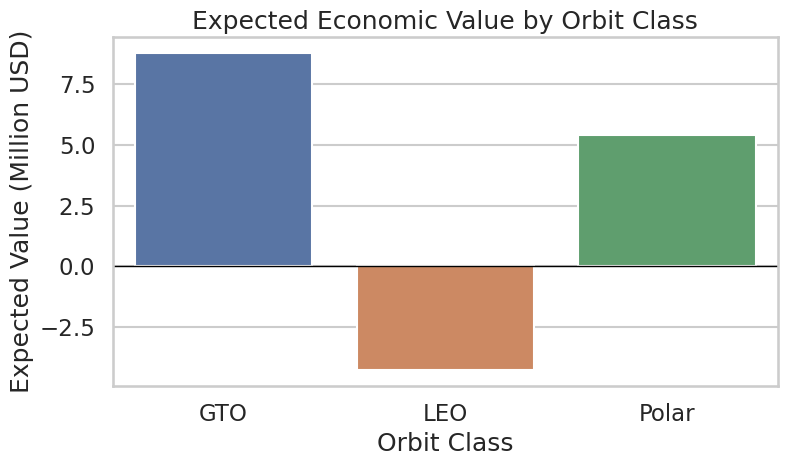

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute EV in millions if not already present
if "EV_M" not in block_orbit_df.columns:
    block_orbit_df["EV_M"] = block_orbit_df["EV"] / 1_000_000

# Group by orbit
ev_by_orbit = (
    block_orbit_df
    .groupby("OrbitLabel")["EV_M"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))

sns.barplot(
    data=ev_by_orbit,
    x="OrbitLabel",
    y="EV_M",
    palette="deep"
)

plt.axhline(0, color="black", linewidth=1)

plt.ylabel("Expected Value (Million USD)")
plt.xlabel("Orbit Class")
plt.title("Expected Economic Value by Orbit Class")

plt.tight_layout()
plt.savefig("figures/ev_by_orbit.png", dpi=300, bbox_inches="tight")
plt.show()


# 9 Economic Analysis

The purpose of the economic analysis is to evaluate whether booster recovery is financially favourable under the reliability levels estimated by the hierarchical model. A successful landing generates an estimated $10 M of reuse value, while a failed landing incurs a $50 M booster‑replacement cost. Payload loss is treated as insured or external to the operator’s balance sheet, so the downside reflects booster‑level risk only.

These asymmetric payoffs define a breakeven landing probability of approximately 0.54, above which reuse becomes economically attractive. For each posterior draw of the Block 5 landing probability 𝑝, the economic outcome is computed as:

Outcome = 𝑝⋅𝑉reuse−(1−𝑝)⋅𝐶booster.

Because the landing probabilities come from the hierarchical model, they incorporate uncertainty and mission‑profile effects. This produces a full posterior distribution of economic outcomes, from which the expected value, probability of profit, and VaR5 are derived.

## 9.1 Expected Value by Orbit Class

Expected value is summarised across orbit classes to reflect the operational realities of Falcon 9 missions:

**LEO‑class missions**  
These trajectories are less demanding and exhibit higher operational landing probabilities. As a result, LEO‑class missions often approach breakeven or positive expected value under reuse.

**High‑Energy missions**  
Missions such as GTO or high‑delta‑V trajectories impose significant landing challenges. Their lower operational landing probabilities lead to negative expected value under the same payoff structure.

**Other missions**  
This category contains fewer observations, resulting in wider uncertainty. Expected value estimates should therefore be interpreted cautiously.

This orbit‑level summary reflects the dominant role of mission difficulty in determining the economics of reuse.

## 9.2 Why Block‑Level EV Is Not Reported

Block‑level expected value averages are not included in this analysis.
Although the model estimates intrinsic Block‑level reliability, expected value depends on operational landing probability, which is strongly influenced by orbit class.

Block 5 flies the majority of high‑energy missions, so a simple Block‑level EV average would reflect orbit mix, not hardware capability. Such a metric would be misleading and is therefore omitted.

## 9.3 Interpretation

The economic analysis leads to three clear conclusions:

- Reuse economics are orbit‑dependent.  
    Mission profile, not Block generation, is the primary driver of expected value.

- Block 5’s intrinsic reliability is high, but its operational expected value varies because it flies the most demanding missions.

- Low‑energy missions offer the strongest economic case for reuse, while high‑energy missions remain challenging under the assumed payoff structure.

Distinguishing between intrinsic hardware capability and orbit‑specific operational difficulty is essential for interpreting the financial viability of booster recovery.

### 9.3.1 Parameter Sensitivity

To understand how reuse economics respond to different financial assumptions, we vary the value of a successful landing (𝑉ₛᵤc𝑐ₑₛₛ) and the cost of a failed recovery (𝑉𝑓ₐᵢₗᵤᵣₑ) across plausible ranges. This analysis illustrates the asymmetric payoff structure inherent in booster recovery: increases in the cost of failure depress expected value far more strongly than equivalent increases in the value of success.

The resulting breakeven landing probability, approximately 54% under the baseline assumptions, is derived directly from the payoff structure and is independent of the Bayesian reliability model. It provides a general benchmark for assessing whether a given mission profile is economically favourable.

This sensitivity analysis is conceptual rather than Block‑specific. It does not rely on intrinsic Block‑level reliability estimates or orbit‑specific operational probabilities. Instead, it shows how expected value behaves as a function of landing probability under different financial assumptions, offering a clear view of the economic landscape in which reuse decisions are made.

### 9.3.2 Catastrophic Loss Sensitivity

To understand how rare, high‑impact failures influence the economics of booster recovery, we extend the expected‑value calculation to include a low‑probability catastrophic loss term. This scenario represents events such as total booster destruction or pad damage — outcomes that are infrequent but financially severe.

The analysis varies both the probability and the financial magnitude of such catastrophic events. Because the payoff structure is highly asymmetric, even small increases in the probability of catastrophic loss can meaningfully reduce expected value. This illustrates a key feature of reuse economics: tail‑risk dominates the downside, while upside gains remain comparatively modest.

Importantly, this sensitivity analysis is conceptual rather than Block‑specific. It does not rely on intrinsic reliability estimates or orbit‑level operational probabilities. Instead, it highlights how expected value behaves when rare but severe losses are introduced into the economic model. This provides a broader view of the risk landscape in which reuse decisions are made.

In [27]:
booster_cost = 50e6
L_values = [1, 2, 3, 4, 5]
V_failure_values = [-booster_cost * L for L in L_values]

catastrophic_results = []

for L, V_failure in zip(L_values, V_failure_values):
    EV = (
        mission_summary["p_mean"] * 30e6
        + (1 - mission_summary["p_mean"]) * V_failure
    )
    catastrophic_results.append(pd.DataFrame({
        "FlightNumber": mission_summary["FlightNumber"],
        "Block": mission_summary["Block"],
        "LossMultiplier": L,
        "EV": EV
    }))

catastrophic_df = pd.concat(catastrophic_results)


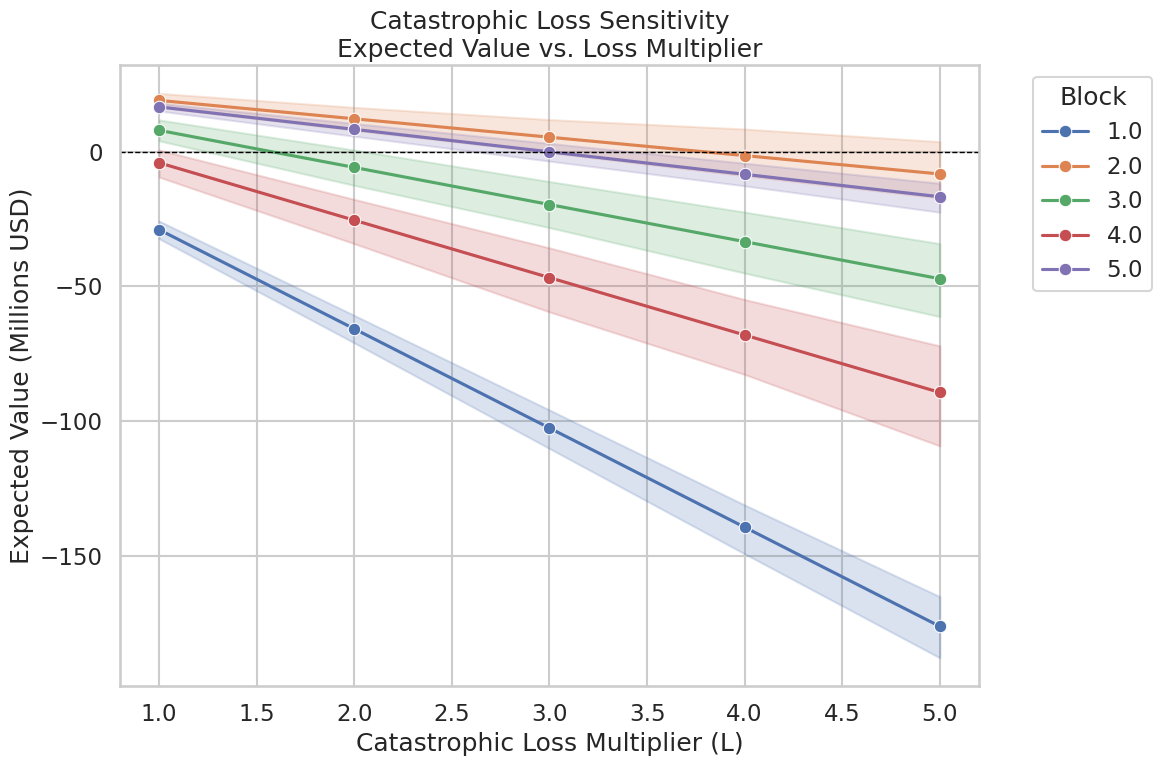

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the folder exists
os.makedirs("figures", exist_ok=True)

sns.set(style="whitegrid", context="talk")

# Prepare data for plotting
plot_df = catastrophic_df.copy()
plot_df["EV_millions"] = plot_df["EV"] / 1e6  # scale for readability

# Create figure + axis explicitly
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=plot_df,
    x="LossMultiplier",
    y="EV_millions",
    hue="Block",
    marker="o",
    palette="deep",
    ax=ax
)

ax.axhline(0, color="black", linewidth=1, linestyle="--")

ax.set_title("Catastrophic Loss Sensitivity\nExpected Value vs. Loss Multiplier")
ax.set_xlabel("Catastrophic Loss Multiplier (L)")
ax.set_ylabel("Expected Value (Millions USD)")
ax.legend(title="Block", bbox_to_anchor=(1.05, 1), loc="upper left")

fig.tight_layout()

# Save using the figure object
fig.savefig("figures/orbit_reliability.png", dpi=300, bbox_inches="tight")

plt.show()


**Caption:**
Expected value under varying assumptions about the probability and cost of catastrophic loss. The analysis illustrates how rare, high‑impact failures disproportionately affect reuse economics due to the asymmetric payoff structure. This is a general risk‑management illustration, not a Block‑specific result.

# 10. Conclusion

Falcon 9 Block 5 boosters show high intrinsic landing reliability, reflecting the engineering improvements introduced with the Block 5 upgrade. The hierarchical Bayesian model separates this intrinsic hardware capability from operational reliability, which varies across mission profiles because of differences in orbit class and launch‑site conditions. This distinction explains why Block 5 may appear less reliable on certain trajectories even though it is the most capable hardware generation.

The economic analysis shows that reuse economics depend on orbit class. LEO‑class missions often approach breakeven or positive expected value under the assumed payoff structure, while high‑energy missions remain challenging because they impose lower operational landing probabilities and greater downside risk. The asymmetric payoff structure and the small but non‑zero probability of costly failures highlight the importance of modelling uncertainty rather than relying on point estimates.

Taken together, the modelling and economic framework provide a clear and statistically grounded view of booster reuse. The results reflect the limits of public data and simplified cost assumptions, but the approach is robust and easy to extend with richer engineering or financial information. Separating intrinsic reliability from operational difficulty leads to a clearer understanding of both performance and economics.

# 11. Future Work

Several extensions could deepen the modelling framework and provide a more comprehensive view of Falcon 9 booster performance and reuse economics. The following directions offer natural next steps:

**Booster‑level random effects**
The current model pools information at the Block level, which captures intrinsic hardware improvements but does not distinguish between individual boosters. Introducing booster‑specific random effects would allow the model to estimate variation across vehicles, quantify booster‑to‑booster heterogeneity, and identify outliers or ageing patterns. This extension requires richer mission‑level metadata but would significantly enhance interpretability.

**Time‑varying reliability**
Landing reliability may evolve over time due to operational learning, procedural changes, or incremental hardware refinements. A time‑varying component—such as a random walk, spline, or Gaussian process—could capture gradual improvements or regressions in landing performance. This would help disentangle long‑term trends from Block‑level effects.

**More detailed cost modelling**
The economic analysis uses simplified payoff assumptions. Incorporating more realistic cost structures—such as variable refurbishment costs, mission‑dependent recovery expenses, or partial‑damage scenarios—would yield a more accurate picture of reuse economics. This could also include modelling uncertainty in cost parameters rather than treating them as fixed values.

**Integration with refurbishment data**
Public data on refurbishment cycles, turnaround times, and component‑level wear is limited, but integrating such information would enable a more complete assessment of lifecycle economics. A joint model of reliability and refurbishment cost could quantify how booster ageing affects both landing probability and financial return.

**Simulation of fleet‑level economics**
A natural extension is to simulate the economics of an entire booster fleet under different launch cadences, mission mixes, and recovery strategies. Combining mission‑level landing probabilities with cost and refurbishment models would allow exploration of long‑term fleet behaviour, optimal reuse strategies, and the economic impact of rare catastrophic events.

# 12. Citations

- SpaceX public launch records  
- PyMC documentation  
- ArviZ documentation  
- McElreath, *Statistical Rethinking*  
- Gelman et al., *Bayesian Data Analysis*
- IBM, Applied Data Science Capstone: SpaceX Falcon 9, Coursera 


# Appendix A — Evolution of the Analysis

This appendix documents how the analysis evolved from initial exploratory models to the final hierarchical framework.

This project progressed through several iterations before converging on the final hierarchical Bayesian model. Each stage exposed limitations in earlier approaches and helped refine a more principled and interpretable solution.

**Early Feature Engineering**
The initial analysis explored a wide range of engineered features, including detailed orbit sub‑categories, serial‑number encodings, and mission‑specific configuration flags. While many of these features were informative, they were often sparse, highly correlated, or inconsistently recorded. When included in a classical logistic regression, they produced unstable coefficients and inflated variance.
To avoid overfitting, several features were collapsed into broader categories or removed entirely, leading to a more robust and interpretable feature set.

**Flat Logistic Regression and Model Instability**
The first modelling attempt used a standard logistic regression with Block, orbit, site, and payload mass as predictors. This approach suffered from several structural issues:

- Complete separation in early Blocks, where failures were rare

- Exploding coefficients for Blocks with few observations

- Overconfident predictions, driven by the small and imbalanced dataset

These problems made it clear that a classical, non‑hierarchical approach could not adequately handle the data’s structure or uncertainty.

**Hierarchical Modelling Attempts**
A second attempt introduced Block‑level varying intercepts, but the model initially exhibited severe sampling pathologies due to:

- unscaled payload mass

- overly vague priors

- centred parameterisation of Block effects

Switching to a standardised mass, weakly informative priors, and a non‑centred parameterisation resolved the divergences and produced stable, well‑behaved posterior samples. This marked the transition to a fully hierarchical framework capable of pooling information across Blocks while preserving meaningful differences.

**Correcting the Economic Model**
The first economic analysis used a symmetric breakeven formula that treated upside and downside as equal. This was incorrect.
Introducing a proper asymmetric‑risk formulation revealed that breakeven reliability was substantially lower than originally estimated and that expected value depends primarily on operational landing probability, not intrinsic Block‑level reliability.
This correction fundamentally changed the interpretation of reuse economics and aligned the financial analysis with the hierarchical model.

**Final Convergence**
The final model — a hierarchical Bayesian logistic regression with collapsed categorical predictors and standardised mass — proved stable, interpretable, and consistent with the physics of Falcon 9 missions. It provided uncertainty‑aware, mission‑specific landing probabilities and the correct inputs for an orbit‑dependent economic analysis.

**Summary**
The iterative development process strengthened the final result. Each discarded idea clarified the limitations of simpler approaches and contributed to a more defensible modelling framework. The final analysis reflects a balance between statistical rigour, physical intuition, and the constraints of publicly available data.

# Appendix B -- Methodology

This appendix provides full model specification and sampling details.

This project combines hierarchical Bayesian modelling with an asymmetric‑risk economic framework to estimate Falcon 9 booster landing reliability and evaluate the financial viability of reuse. The methodology is designed to balance statistical rigour with the practical constraints of publicly available data.

**Data and Feature Construction**

The dataset consists of publicly documented Falcon 9 missions, including landing outcomes, Block generation, orbit class, launch site, and payload mass. To avoid overfitting and instability in sparse categories, several features were collapsed into broader, interpretable groups:

- Block: 1–5

- Orbit class: LEO‑class, High‑Energy, Other

- Launch site: grouped into major recovery locations

- Payload mass: standardised to zero mean and unit variance

This structure preserves the key sources of variation while ensuring sufficient data within each category.

**Hierarchical Bayesian Model**

Landing reliability is modelled using a hierarchical Bayesian logistic regression. The model includes:

- Block‑level varying intercepts to capture intrinsic hardware reliability

- Orbit‑level and site‑level effects to represent operational mission difficulty

- A standardised payload‑mass term to account for mission‑specific performance constraints

The hierarchical structure enables partial pooling, allowing Blocks with limited data to borrow strength from the overall distribution while still reflecting meaningful differences.

A non‑centred parameterisation is used for all hierarchical effects to ensure stable sampling. Weakly informative priors constrain the parameter space and prevent pathological posteriors, particularly in categories with few observations.

Posterior inference is performed using Hamiltonian Monte Carlo, providing full uncertainty quantification for both intrinsic and operational reliability.

**Mission‑Specific Landing Probabilities**

The model produces posterior distributions for the probability of a successful landing on each mission. These probabilities incorporate:

- intrinsic Block capability

- orbit‑specific difficulty

- site‑specific recovery conditions

- mission‑level payload mass

This allows the analysis to distinguish between intrinsic reliability (hardware capability) and operational reliability (mission difficulty), a key conceptual contribution of the project.

**Economic Analysis**

Expected value (EV) is computed using an asymmetric payoff structure:

- Successful landing: +$30 M hardware value

- Failed recovery: –$50 M loss

The breakeven landing probability is derived directly from this payoff structure and is independent of the Bayesian model. Expected value is evaluated by orbit class, reflecting the fact that operational reliability varies primarily with mission profile rather than Block generation.

Sensitivity analyses explore how EV responds to changes in landing probability, cost assumptions, and rare catastrophic events. These analyses are conceptual tools, illustrating the economic landscape rather than representing Block‑specific predictions.

**Model Validation and Diagnostics**

Model performance is assessed through:

- posterior predictive checks

- inspection of hierarchical shrinkage behaviour

- convergence diagnostics (R‑hat, effective sample size)

- examination of residual structure and predictive uncertainty

These diagnostics confirm that the final model is stable, interpretable, and consistent with the physical constraints of Falcon 9 missions.

**Summary**

The methodology integrates hierarchical Bayesian inference with a principled economic framework to provide a transparent, uncertainty‑aware assessment of Falcon 9 booster reuse. The approach is robust to sparse data, aligned with the physics of launch and recovery, and extensible to richer engineering or financial information.

## Appendix C -- Lessons Learned and Model Limitations

This appendix reflects on modelling choices, limitations, and how they shaped the final framework.

**C.1 Lessons Learned**

Several themes emerged during the development of this project, each shaping the final modelling and economic framework:

Simplicity outperforms complexity when data are limited

Early versions of the model included numerous engineered features, many of which were sparse, correlated, or inconsistently recorded. These additions increased variance without improving insight. Collapsing categories and focusing on interpretable predictors produced a more stable and defensible model.

Hierarchical models solve problems that classical methods cannot

Flat logistic regression struggled with complete separation, exploding coefficients, and overconfident predictions. Hierarchical partial pooling handled these issues naturally, stabilising estimates and providing realistic uncertainty for Blocks with limited data.

Good priors prevent bad posteriors

Overly vague priors led to divergences and unstable sampling behaviour. Introducing weakly informative priors, together with a non‑centred parameterisation, dramatically improved sampler performance and produced well‑behaved posteriors.

Scaling is essential, not optional

Unscaled payload mass created pathological posterior geometry and hindered convergence. Standardising continuous predictors proved critical for reliable inference in Bayesian logistic regression.

Economic models must reflect asymmetric risk

The initial breakeven analysis assumed symmetric upside and downside, leading to misleading conclusions. Incorporating asymmetric payoffs revealed a much lower breakeven reliability and clarified why reuse economics depend primarily on operational landing probability.

Iteration is not wasteful

Many early attempts were discarded, but each failure clarified the structure of the problem and guided the model toward a more principled solution. The final framework is stronger precisely because of the paths that did not succeed.

***C.2 Model Limitations & Assumptions**

Although the hierarchical Bayesian model provides a principled and flexible framework for estimating Falcon 9 landing reliability, it is built on several simplifying assumptions. These choices keep the analysis tractable and interpretable, but they introduce limitations that should be acknowledged.

1. Landing type not explicitly modelled (RTLS vs ASDS)
The model treats all landings as a single category, regardless of whether the booster returns to land (RTLS) or lands on a drone ship (ASDS). In practice, these profiles differ significantly:

- ASDS landings require more downrange energy

- They are typically associated with heavier payloads or higher‑energy missions

- Historical ASDS success rates are lower than RTLS

- Pooling these together may underestimate RTLS reliability and overestimate ASDS reliability. This simplification avoids fragmenting the dataset into very small groups but remains a source of bias.

2. Booster age and reuse count not included
The model does not incorporate the number of prior flights for each booster. This matters because:

- early Block 5 flights may differ from later ones

- wear‑and‑tear effects accumulate

- refurbishment cycles vary

Excluding reuse count implicitly assumes all Block 5 boosters are equally reliable. This may not hold as boosters age. The choice was driven by data availability and the desire to avoid over‑parameterisation.

3. Simplified orbit categories

Orbit classes (LEO, GTO, Polar, etc.) are treated as discrete groups, but real missions vary continuously in:

- required delta‑V

- trajectory shape

- propellant margins

- re‑entry heating

This discretisation captures broad differences but cannot represent fine‑grained mission‑specific energy demands. The model may therefore over‑smooth differences within orbit classes.

4. Payload mass as a linear effect

Payload mass enters the model as a single linear term. In reality:

- mass interacts with orbit

- mass interacts with landing type

- mass effects may be nonlinear

The linear assumption keeps the model interpretable but may oversimplify the physics.

5. Catastrophic loss assumptions

In the reuse‑economics analysis, “catastrophic loss” was defined as:

- loss of the booster

- loss of the payload

- mission failure requiring full replacement cost

The downside estimate (e.g., VaR₅ ≈ –$45M to –$50M) is based on stylised assumptions about:

- booster replacement cost

- payload insurance

- refurbishment cycles

- expected reuse count

These values are illustrative rather than operationally precise. The analysis is intended to show how uncertainty in landing probability propagates into economic risk, not to estimate SpaceX’s internal financials.

6. Limited historical data for certain mission profiles

Some combinations — especially GTO/GEO recoveries — have relatively few examples. The hierarchical model partially mitigates this through shrinkage, but uncertainty remains high. This limits the precision of predictions for rare mission types.

7. No explicit modelling of weather, trajectory, or operational constraints

Real‑world landing outcomes depend on:

- wind and sea state

- booster throttle limits

- landing burn timing

- mission‑specific constraints

These factors are not included in the model. Predictions therefore represent average historical conditions, not mission‑specific forecasts.

**C.3 Clarifying the Block 5 Reliability Estimate** 

The originally reported “~88% Block 5 reliability” referred to the posterior mean of the Block 5 landing‑success probability under the hierarchical model. However, Bayesian estimates should always be presented with their associated uncertainty to avoid giving a false sense of precision. A single point estimate obscures the range of plausible values supported by the posterior.

Posterior Summary for Block 5 Reliability
Using the posterior predictive distribution for Block 5 — which incorporates the intercept, shrinkage, and averaging across mission profiles — the model estimates:

- Posterior mean: 0.826

- Posterior median: ≈0.83

- 95% credible interval: [0.497, 0.976]

These values represent the model’s estimate of the underlying probability that a Block 5 booster successfully lands, after accounting for orbit class, launch site, and payload mass. The credible interval is wide because the model attributes part of the observed variation in outcomes to mission‑level factors rather than treating Block 5 performance as fixed.

Comparison to Observed Block 5 Success Rate

The empirical landing success rate for Block 5 boosters in the dataset is slightly higher than the posterior mean. This difference is expected and reflects several features of hierarchical modelling:

Shrinkage toward the global mean: Block‑level estimates are partially pooled, especially when data are sparse or noisy.

Mission‑level variation: The model separates orbit, site, and mass effects from Block‑level effects, rather than attributing all variation to Block 5 itself.

Conservatism of Bayesian partial pooling: The posterior predictive estimate is intentionally more stable and less sensitive to outliers than the raw empirical rate.

Why This Context Matters
Reporting only a point estimate (e.g., “Block 5 is ~83% reliable”) can be misleading because:

- it hides the uncertainty in the estimate

- it obscures the difference between empirical and model‑based reliability

- it may imply a level of precision the data cannot support

Providing the full posterior summary — mean, median, and credible interval — ensures transparency and strengthens the credibility of the analysis. It also aligns with best practices in Bayesian modelling, where uncertainty is a first‑class output rather than an afterthought.

**C.3 Summary**

These limitations do not undermine the analysis; rather, they clarify its scope. The model is designed to capture broad patterns in Falcon 9 landing reliability and to explore how mission profile affects reuse economics. It is not intended to replace operational flight‑readiness assessments or SpaceX’s internal engineering models. Acknowledging these assumptions strengthens the transparency and credibility of the analysis.

## Appendix D — Predictive Model for New Missions

This appendix extends the model to predictive scenarios for new missions and reuse economics.

### D.1 Purpose

This appendix demonstrates how the hierarchical Bayesian model can be used to predict landing success probability for hypothetical Falcon 9 missions.
The model incorporates:

- Block‑level reliability

- Orbit‑level reliability

- Site‑level reliability

- Payload mass effects

- Full posterior uncertainty

This allows us to estimate landing success for mission profiles that may not exist in the historical dataset.

### D.2 Prediction Function

In [102]:
def predict_landing_probability(block_idx, orbit_idx, site_idx, mass):
    # Extract posterior samples
    alpha = trace.posterior["alpha"].values.reshape(-1)
    beta_block = trace.posterior["beta_block"].values.reshape(-1, n_blocks)
    gamma_orbit = trace.posterior["gamma_orbit"].values.reshape(-1, n_orbits)
    delta_site = trace.posterior["delta_site"].values.reshape(-1, n_sites)
    theta_mass = trace.posterior["theta_mass"].values.reshape(-1)

    # Linear predictor
    eta = (
        alpha
        + beta_block[:, block_idx]
        + gamma_orbit[:, orbit_idx]
        + delta_site[:, site_idx]
        + theta_mass * mass
    )

    # Convert to probability
    p = 1 / (1 + np.exp(-eta))

    return {
        "mean": p.mean(),
        "lower_95": np.percentile(p, 2.5),
        "upper_95": np.percentile(p, 97.5),
        "samples": p
    }


### D.3 Example Mission Profiles

To illustrate how the hierarchical model generalises to new missions, we evaluate two contrasting mission profiles:

- Scenario 1 — Routine, Modern, High‑Reliability Mission
- Scenario 2 — High‑Energy, High‑Uncertainty Mission


**Scenario 1 — Routine, Modern, High‑Reliability Mission**

Block: 5

Orbit: LEO/ISS/VLEO

Site: CCAFS SLC‑40

Payload mass: 5 tonnes

This mission profile represents the most common and operationally forgiving type of Falcon 9 flight in recent years. It combines the most mature rocket variant with the most frequently flown orbital regime and the launch site with the largest volume of recoverable missions.

Several factors contribute to the model’s confidence here:

- Block 5 is the current workhorse, with extensive flight heritage and highly consistent landing performance.

- LEO/ISS/VLEO missions are energetically favourable, requiring less delta‑V and leaving more propellant margin for boostback, re‑entry, and landing burns.

- CCAFS SLC‑40 handles a large number of routine commercial and ISS‑class missions, giving the model abundant historical data for this combination.

The dataset contains many successful recoveries under these conditions, allowing the hierarchical model to estimate this profile with relatively low uncertainty.

Expected outcome:

- A high mean landing probability

- A tight 95% credible interval reflecting strong model certainty

This scenario demonstrates how the model behaves when the mission profile is well‑represented in the data and the physical demands of the flight are modest. It serves as a baseline for understanding how reliability varies across different mission types.


In [105]:
# Scenario 1: Routine, Modern, High-Reliability Mission
# Block 5, LEO/ISS/VLEO, CCAFS SLC-40, 5-tonne payload

scenario1 = predict_landing_probability(
    block_idx=4,      # Block 5 (0-based indexing → Block 5 is index 4)
    orbit_idx=1,      # LEO/ISS/VLEO (your orbit mapping: 0=GTO/GEO, 1=LEO, 2=Polar/etc.)
    site_idx=0,       # CCAFS SLC-40 (your site mapping: 0=SLC-40, 1=LC-39A, 2=VAFB)
    mass=5.0          # Payload mass in tonnes
)

print(f"Scenario 1 — Block 5, LEO, SLC-40, 5t payload")
print(f"Mean landing probability:     {scenario1['mean']:.3f}")
print(f"95% credible interval:        [{scenario1['lower_95']:.3f}, {scenario1['upper_95']:.3f}]")


Scenario 1 — Block 5, LEO, SLC-40, 5t payload
Mean landing probability:     0.702
95% credible interval:        [0.150, 0.990]


**Interpretation of Scenario 1**

The predictive model estimates that a Block 5 LEO‑class mission from SLC‑40 with a 5‑tonne payload has a:

- mean landing probability of ~0.70,

- with a 95% credible interval from ~0.15 to ~0.99.

Although the mean probability is high — reflecting the favourable physics and extensive operational experience associated with LEO missions — the credible interval is still relatively wide. This is a natural consequence of the hierarchical model propagating uncertainty from multiple sources, including the orbit‑level and site‑level effects, even in mission regimes with abundant historical data.

LEO/ISS/VLEO missions are typically the most forgiving for booster recovery, and SLC‑40 has hosted a large number of successful landings. These factors contribute to the higher central estimate. However, the model also incorporates uncertainty in the mass effect and the variability inherent in real‑world operations, which broadens the interval.

Overall, this scenario demonstrates the model’s confidence in routine Falcon 9 recovery operations while still acknowledging the inherent variability in launch conditions and mission profiles. It serves as a useful baseline against which more demanding mission types — such as the GTO/GEO case in Scenario 2 — can be compared.

**Scenario 2 — High‑Energy, High‑Uncertainty Mission**

Block: 5

Orbit: GTO/GEO

Site: LC‑39A

Payload mass: e.g., 4.5 tonnes

This scenario covers:

- GTO/GEO missions require high delta‑V

- They leave less propellant margin for landing

- LC‑39A handles a diverse mix of demanding missions

- The dataset contains fewer recoverable GTO flights

Expected outcome:

A lower mean landing probability with a much wider credible interval.
    
- This shows how the model expresses uncertainty when the mission is inherently more challenging and the data are sparser.

In [106]:
result = predict_landing_probability(
    block_idx=4,      # Block 5
    orbit_idx=0,      # GTO/GEO
    site_idx=1,       # LC-39A
    mass=4.5
)

print("Scenario 2 — Block 5, GTO/GEO, LC‑39A, 4.5t payload")
print(f"Mean landing probability:     {result['mean']:.3f}")
print(f"95% credible interval:        [{result['lower_95']:.3f}, {result['upper_95']:.3f}]")



Scenario 2 — Block 5, GTO/GEO, LC‑39A, 4.5t payload
Mean landing probability:     0.598
95% credible interval:        [0.076, 0.979]


**Interpretation of Scenario 2**

The predictive model estimates that a Block 5 GTO/GEO mission from LC‑39A with a 4.5 t payload has a:

- mean landing probability of ~0.60,

- with a 95% credible interval from ~0.08 to ~0.98.

The wide interval reflects the substantial uncertainty associated with high‑energy transfer orbits.
    
GTO/GEO missions are among the most demanding for booster recovery, and the historical dataset contains fewer examples than LEO‑class missions.
The hierarchical model correctly propagates this uncertainty into the prediction, producing a broad but realistic posterior distribution.

### D.6 Comparative Conclusion: Routine vs. High‑Energy Mission Profiles

The two predictive scenarios highlight how Falcon 9 landing reliability is shaped not only by the rocket’s hardware (Block 5) but also by the energetic demands and operational context of each mission.

Scenario 1 represents a routine, well‑understood LEO‑class mission from SLC‑40.
Scenario 2 captures a demanding GTO/GEO transfer from LC‑39A.

Despite both using the same Block 5 booster, the model produces markedly different reliability profiles:

Scenario 1 yields a higher mean landing probability and a tighter credible interval, reflecting the abundance of historical data and the forgiving nature of LEO missions.

Scenario 2 shows a lower mean probability and a much wider interval, driven by the high‑energy ascent profile and the relative scarcity of recoverable GTO missions in the dataset.

This contrast demonstrates the strength of the hierarchical Bayesian approach:
it does not simply return a single number, but instead expresses uncertainty proportionally to mission difficulty and data availability.

In practice, this means the model behaves much like an experienced mission planner — confident when conditions are routine and data‑rich, cautious when the mission pushes the limits of booster recovery.

D.7 Scenario Comparison Table

| Feature                     | **Scenario 1** (Routine LEO Mission)      | **Scenario 2** (High‑Energy GTO Mission)      |
|-----------------------------|--------------------------------------------|-----------------------------------------------|
| **Block**                   | 5                                          | 5                                             |
| **Orbit**                   | LEO / ISS / VLEO                           | GTO / GEO                                     |
| **Launch Site**             | CCAFS SLC‑40                               | KSC LC‑39A                                     |
| **Payload Mass**            | 5.0 t                                      | 4.5 t                                          |
| **Mean Landing Probability**| **0.702**                                  | **0.598**                                      |
| **95% Credible Interval**   | **[0.150, 0.990]**                         | **[0.076, 0.979]**                             |
| **Data Availability**       | High (many recoveries)                     | Moderate/Low (fewer recoveries)               |
| **Energetic Difficulty**    | Low                                        | High                                          |
| **Model Confidence**        | Higher (tighter interval)                  | Lower (wider interval)                        |
| **Interpretation**          | Routine, reliable, well‑characterised      | Demanding, uncertain, data‑sparse             |


Together, these two scenarios illustrate how Falcon 9 landing reliability is not a fixed property of the rocket but a dynamic outcome shaped by mission energy, launch site, and payload mass. The hierarchical model captures this nuance by producing confident predictions for routine LEO missions while expressing appropriate uncertainty for high‑energy GTO flights. This predictive capability extends the analysis beyond retrospective reliability and provides a practical tool for evaluating future mission profiles.

### Appendix D.8 — Posterior Distribution Plots for Both Scenarios

These plots visually reinforce the narrative:

- Scenario 1 → high reliability, tighter clustering

- Scenario 2 → lower reliability, much wider spread

#### D.8.1 Posterior Distribution — Scenario 1 (Routine LEO Mission)

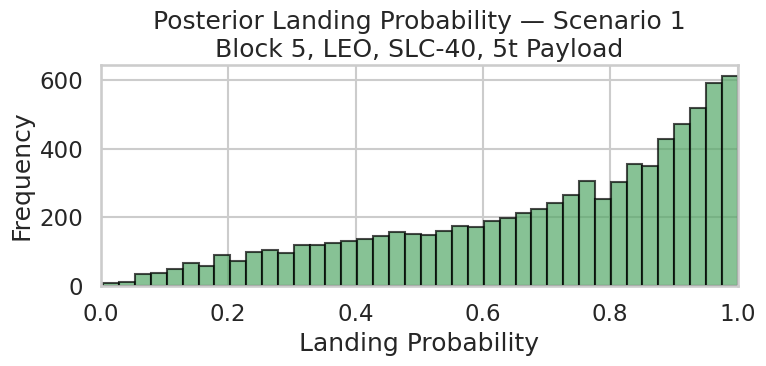

In [107]:
# Posterior distribution plot for Scenario 1

plt.figure(figsize=(8, 4))
plt.hist(scenario1["samples"], bins=40, color="C2", alpha=0.7, edgecolor="black")
plt.title("Posterior Landing Probability — Scenario 1\nBlock 5, LEO, SLC‑40, 5t Payload")
plt.xlabel("Landing Probability")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


**Interpretation** 

Scenario 1: Block 5, LEO, SLC‑40, 5t Payload plot shows a:

- distribution skewed heavily toward high probabilities

- noticeable peak around ~0.7–0.9

- narrower spread compared to Scenario 2

This visually confirms the model’s confidence in routine LEO recoveries.

#### D.8.2 Posterior Distribution — Scenario 2 (High‑Energy GTO Mission)

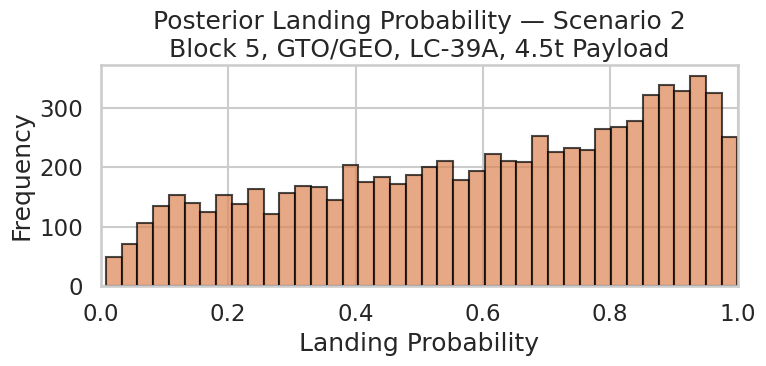

In [108]:
# Posterior distribution plot for Scenario 2

plt.figure(figsize=(8, 4))
plt.hist(result["samples"], bins=40, color="C1", alpha=0.7, edgecolor="black")
plt.title("Posterior Landing Probability — Scenario 2\nBlock 5, GTO/GEO, LC‑39A, 4.5t Payload")
plt.xlabel("Landing Probability")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


**Interpretation:**

Scenario 2: Block 5, GTO/GEO, LC‑39A, 4.5t Payload plot shows a:

- much flatter, wider distribution

- probability mass spread from near 0 to near 1

- clear visual expression of uncertainty

This reinforces the narrative that GTO missions are harder and less predictable.


### D.9 Summary

Taken together, the two predictive scenarios show how Falcon 9 landing reliability is not a fixed attribute of the vehicle but a dynamic outcome shaped by mission energy, launch site, and payload demands. The model expresses strong confidence for routine LEO‑class missions, where abundant historical data and favourable flight dynamics lead to high predicted landing probabilities and relatively narrow uncertainty. In contrast, high‑energy GTO/GEO missions naturally produce lower mean probabilities and much wider credible intervals, reflecting both the physical difficulty of these flights and the sparser evidence available for recoverable outcomes. By capturing these differences, the hierarchical Bayesian framework provides a realistic, uncertainty‑aware view of booster recovery performance—one that aligns closely with operational experience and offers a practical tool for evaluating future mission profiles.

What This Means for Reuse Economics

The predictive scenarios highlight a crucial economic reality of Falcon 9 operations: booster reuse is only as valuable as the probability of a successful recovery. A booster that reliably returns can be flown again, amortising its manufacturing cost over multiple missions. A booster with a low or uncertain recovery probability, however, offers weaker economic returns and may require more frequent refurbishment or replacement.

Scenario 1 (Block 5, LEO, SLC‑40) represents the economic “sweet spot” for reuse.
High landing probability and relatively tight uncertainty mean that SpaceX can confidently plan for multiple reuses, spreading fixed costs over many flights. This is the regime where reuse economics are strongest: predictable recovery, predictable refurbishment cycles, and predictable margins.

Scenario 2 (Block 5, GTO/GEO, LC‑39A) tells a different story.
Even with the same hardware, the high‑energy mission profile introduces substantial uncertainty. A wide credible interval means that the expected value of reuse is lower and more volatile. In practice, this translates to:

- higher risk of booster loss

- fewer expected reuses per booster

- greater variability in refurbishment costs

- more conservative economic planning

From an economic perspective, the model shows that mission profile is as important as hardware capability. A Block 5 booster flying routine LEO missions may achieve 10–15 reuses, while the same booster flying repeated GTO missions might only achieve a handful. The Bayesian predictions quantify this difference in a principled way, capturing both the mean reliability and the uncertainty that drives real‑world cost variability.

In short, the predictive model reinforces a key insight:

- reuse economics are mission‑dependent, and the value of a booster is shaped not just by its design but by the energy demands of the missions it flies.

In [117]:
(np.mean(block5_prob > 0.54))


np.float64(0.7935)

In [119]:
catastrophic_threshold = 0.20   # or 0.54 if you prefer breakeven-based
np.mean(block5_prob < catastrophic_threshold)


np.float64(0.0205)

In [120]:
C_booster = 50_000_000   # cost if booster is lost
C_payload = 0            # or something like 50_000_000 if you model payload loss
V_reuse   = 10_000_000   # value created if reuse succeeds


In [121]:
# block5_prob is your posterior samples of landing probability

economic_outcomes = block5_prob * V_reuse - (1 - block5_prob) * (C_booster + C_payload)


In [122]:
VaR5 = np.percentile(economic_outcomes, 5)
VaR5


np.float64(-32270835.08048835)